In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torch_directml
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchmetrics.image import StructuralSimilarityIndexMeasure, PeakSignalNoiseRatio
from torchvision import transforms
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2
from piqa import MS_SSIM

In [2]:
# use CUDA processors if available
device = "cuda" if torch.cuda.is_available() else "cpu"
# device = torch_directml.device()
print(f"Using {device} device")

Using cpu device


In [7]:
def get_img_path(digit, i):
    # get the image path given the digit and the index of the image within the digit
    # eg. get_img_path(4, 12) denotes the 13th image of digit 4
    if digit == 0:
        img_num = 9000
    else:
        img_num = (digit - 1) * 1000
    img_num += (i+1)
    return f'../data/labels/{digit}/image{img_num}.png'


def gather_data(exp_type: str, detect_type: str, feature_name: str):
    # prepare feature data and image paths
    features = None
    image_paths = []
    digits = []
    for digit in range(10):
        fpath = f'../data/features/{exp_type}/{detect_type}/{feature_name}/{feature_name}{digit}.csv'
        data = pd.read_csv(fpath, header=None)

        for i in range(len(data)):
            dig = data[0][i]
            image_paths.append(get_img_path(dig, i))
            digits += [dig]

        data = data.drop(0, axis=1)
        if features is None:
            features = data.to_numpy()
        else:
            features = np.append(features, data.to_numpy(), axis=0)

    features = torch.tensor(features.astype(np.float32)).to(device)
    return features, image_paths, digits

# define data transformations
def feature_transform(x: torch.Tensor):
    # standardizes the features of a given data point
    x = x[:100]
    mean = x.mean()
    std = x.std()
    return x.sub(mean).div(std).to(device)


def img_transform(y: str):
    # transforms an image path to a usable tensor
    image = cv2.imread(y, cv2.IMREAD_GRAYSCALE)
    convert_tensor = A.Compose([A.ToFloat(max_value=255), ToTensorV2()])
    try:
        thingy = convert_tensor(image=image)['image']
        return thingy.to(device)
    except Exception as e:
        print(e)
        raise Exception(f"cannot load image: {y}")


def digit_transform(y: int):
    return y


# create Datasets and DataLoaders
class ReconstructionData(Dataset):
    def __init__(self, raw_features: torch.Tensor, labels: list, feature_transform, label_transform: None):
        self.features = raw_features
        self.labels = labels
        self.feature_transform = feature_transform
        self.label_transform = label_transform

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        data = self.feature_transform(self.features[idx])
        label = self.label_transform(self.labels[idx])
        return data, label


def prep_data(features, labels, val_size, feature_transform, label_transform, batch_size):
    # create train and validation dataloaders
    train_features, val_features, train_labels, val_labels = train_test_split(features, labels, test_size=val_size)
    train_data = ReconstructionData(train_features, train_labels, feature_transform, label_transform)
    val_data = ReconstructionData(val_features, val_labels, feature_transform, label_transform)
    train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(val_data, batch_size=batch_size, shuffle=True)
    return train_dataloader, val_dataloader


class ImgReconstructNN(nn.Module):
    def __init__(self):
        super(ImgReconstructNN, self).__init__()
        self.reconstruct_stack = nn.Sequential(
            nn.Linear(100, 1024),
            nn.PReLU(),
            nn.Linear(1024, 4096),
            nn.PReLU(),
            nn.Linear(4096, (4*28)*(4*28)),
            nn.Sigmoid(),
            nn.Unflatten(1, (1, 4*28, 4*28)),
            nn.Conv2d(1,4,4,padding=2),
            nn.MaxPool2d(2),
            nn.Conv2d(4,1,2,padding=1),
            nn.MaxPool2d(2),
            nn.Sigmoid(),
        )

    def forward(self, x):
        logits = self.reconstruct_stack(x)
        return logits


class ImgReconstructClassifyNN(nn.Module):
    def __init__(self):
        super(ImgReconstructClassifyNN, self).__init__()
        self.reconstruct_classify_stack = nn.Sequential(
            nn.Linear(300, 2048),
            nn.PReLU(),
            nn.Linear(2048, 2048),
            nn.PReLU(),
            nn.Linear(2048, (8*28)*(8*28)),
            nn.Sigmoid(),
            nn.Unflatten(1, (1, 8*28, 8*28)),
            nn.Conv2d(1, 1, 8, padding=4),
            nn.MaxPool2d(2),
            nn.Conv2d(1, 1, 4, padding=2),
            nn.MaxPool2d(2),
            nn.Conv2d(1, 1, 2, padding=1),
            nn.MaxPool2d(2),
            nn.Sigmoid(),
            nn.Conv2d(1, 10, 5),
            nn.MaxPool2d(2),
            nn.PReLU(),
            nn.Conv2d(10, 20, 5),
            nn.MaxPool2d(2),
            nn.PReLU(),
            nn.Linear(320, 50),
            nn.PReLU(),
            nn.Linear(50, 10),
            nn.Softmax(),
        )

    def forward(self, x):
        logits = self.reconstruct_classify_stack(x)
        return logits


# Training loop
def train_loop(dataloader: DataLoader, val_dataloader: DataLoader, model: nn.Module, loss_fn, optimizer, print_loss: bool, train_losses: list, val_losses: list) -> list:
    model.train()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    train_loss = 0
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)
        train_loss += loss

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss /= num_batches
    train_losses.append(train_loss)
    if print_loss:
        print(f"Avg batch loss: {train_loss:>8f}")

    model.eval()
    with torch.no_grad():
        test_loss = 0
        for (X, y) in val_dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
        train_loss /= num_batches
        val_losses.append(test_loss)
    model.train()

    return train_losses, val_losses


def reconstruct_test_loop(dataloader, model, loss_fn):
    model.eval()
    print("Running Test Loop")
    num_batches = len(dataloader)
    test_loss = 0
    test_psnr = 0
    test_ssim = 0
    psnr = PeakSignalNoiseRatio().to(device)
    ssim = StructuralSimilarityIndexMeasure().to(device)

    with torch.no_grad():
        for batch, (X, y) in enumerate(dataloader):
            print(f"batch: {batch+1}")
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            test_ssim += ssim(pred, y).item()
            test_psnr += psnr(pred, y).item()

            # display 1 original and predicted image from each batch
            transform = transforms.ToPILImage()
            orig_data = y[0]
            orig_img = transform(orig_data)
            pred_data = pred[0]
            pred_img = transform(pred_data)
            diff_data = torch.abs(pred_data - orig_data)
            diff_img = transform(diff_data)
            print("original:")
            display(orig_img)
            print("predicted:")
            display(pred_img)
            print("difference:")
            display(diff_img)
            print()

    test_loss /= num_batches
    test_psnr /= num_batches
    test_ssim /= num_batches
    print(f"Avg batch loss: {test_loss:>8f}")
    print(f"Avg batch PSNR: {test_psnr:>8f}")
    print(f"Avg batch SSIM: {test_ssim:>8f}")
    return model, test_loss, test_psnr, test_ssim


def reconstruct_test_loop(dataloader, model, loss_fn):
    model.eval()
    print("Running Test Loop")
    num_batches = len(dataloader)
    test_loss = 0
    test_psnr = 0
    test_ssim = 0
    psnr = PeakSignalNoiseRatio().to(device)
    ssim = StructuralSimilarityIndexMeasure().to(device)

    with torch.no_grad():
        for batch, (X, y) in enumerate(dataloader):
            print(f"batch: {batch+1}")
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            test_ssim += ssim(pred, y).item()
            test_psnr += psnr(pred, y).item()

            # display 1 original and predicted image from each batch
            transform = transforms.ToPILImage()
            orig_data = y[0]
            orig_img = transform(orig_data)
            pred_data = pred[0]
            pred_img = transform(pred_data)
            diff_data = torch.abs(pred_data - orig_data)
            diff_img = transform(diff_data)
            print("original:")
            display(orig_img)
            print("predicted:")
            display(pred_img)
            print("difference:")
            display(diff_img)
            print()

    test_loss /= num_batches
    test_psnr /= num_batches
    test_ssim /= num_batches
    print(f"Avg batch loss: {test_loss:>8f}")
    print(f"Avg batch PSNR: {test_psnr:>8f}")
    print(f"Avg batch SSIM: {test_ssim:>8f}")
    return model, test_loss, test_psnr, test_ssim


def reconstruct_test_loop(dataloader, model, loss_fn):
    model.eval()
    print("Running Test Loop")
    num_batches = len(dataloader)
    test_loss = 0
    test_psnr = 0
    test_ssim = 0
    psnr = PeakSignalNoiseRatio().to(device)
    ssim = StructuralSimilarityIndexMeasure().to(device)

    with torch.no_grad():
        for batch, (X, y) in enumerate(dataloader):
            print(f"batch: {batch+1}")
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            test_ssim += ssim(pred, y).item()
            test_psnr += psnr(pred, y).item()

            # display 1 original and predicted image from each batch
            transform = transforms.ToPILImage()
            orig_data = y[0]
            orig_img = transform(orig_data)
            pred_data = pred[0]
            pred_img = transform(pred_data)
            diff_data = torch.abs(pred_data - orig_data)
            diff_img = transform(diff_data)
            print("original:")
            display(orig_img)
            print("predicted:")
            display(pred_img)
            print("difference:")
            display(diff_img)
            print()

    test_loss /= num_batches
    test_psnr /= num_batches
    test_ssim /= num_batches
    print(f"Avg batch loss: {test_loss:>8f}")
    print(f"Avg batch PSNR: {test_psnr:>8f}")
    print(f"Avg batch SSIM: {test_ssim:>8f}")
    return model, test_loss, test_psnr, test_ssim


def train_model(train_dataloader, test_dataloader, model, loss_fn, optimizer, epochs):
    train_losses = []
    val_losses = []
    for t in range(epochs):
        print_loss = False
        if (t % 8 == 7) or (t==0):
            print_loss = True
            print("-------------------------------")
            print(f"Epoch {t+1}")
        train_losses, val_losses = train_loop(train_dataloader, test_dataloader, model, loss_fn, optimizer, print_loss, train_losses, val_losses)
    print("Done!")
    return train_losses, val_losses


def plot_loss(losses: list, val: bool) -> None:
    losses = np.array(torch.tensor(losses).cpu())
    plt.plot(losses, color='red')
    plt.ylabel('Average Batch Loss') #set the label for y axis
    plt.xlabel('Epoch') #set the label for x-axis
    if val:
        plt.title("Validation Loss over Epochs") #set the title of the graph
    else:
        plt.title("Training Loss over Epochs") #set the title of the graph
    plt.show() #display the graph


l1 = nn.L1Loss()
class L1_SSIM_loss(MS_SSIM):
    def forward(self, x, y):
        return (0.5 * (1. - super().forward(x, y))) + (0.5 * l1.forward(x, y))


def reconstruct(exp_type, detect_type, feature_name, batch_size, val_size, epochs, loss_fn, learning_rate):
    print(f"\nTRAINING RECONSRTUCTION MODEL FOR: {feature_name}\n")
    print("PART 1")
    features, image_paths, digits = gather_data(exp_type, detect_type, feature_name)
    print("PART 2")
    train_dataloader, val_dataloader = prep_data(features, image_paths, val_size, feature_transform, img_transform, batch_size)
    print("PART 3")
    model = ImgReconstructNN().to(device)
    print(model)
    print("PART 4")
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
    print("PART 5")
    train_losses, val_losses = train_model(train_dataloader, val_dataloader, model, loss_fn, optimizer, epochs)
    print("PART 6")
    plot_loss(train_losses, False)
    plot_loss(val_losses, True)
    print("PART 7")
    model, val_loss, val_psnr, val_ssim = reconstruct_test_loop(val_dataloader, model, loss_fn)
    saved_losses_loc = f'../data/features/{exp_type}/{detect_type}/{feature_name}/100_reconstruct_losses.pt'
    torch.save((train_losses, val_loss), saved_losses_loc)
    return val_loss, val_psnr, val_ssim

def classify_one_model(exp_type, detect_type, feature_name, batch_size, val_size, epochs, loss_fn, learning_rate):
    print(f"\nTRAINING CLASSIFICATION MODEL FOR: {feature_name}\n")
    print("PART 1")
    features, image_paths, digits = gather_data(exp_type, detect_type, feature_name)
    print("PART 2")
    train_dataloader, val_dataloader = prep_data(features, digits, val_size, feature_transform, digit_transform, batch_size)
    print("PART 3")
    model = ImgReconstructClassifyNN().to(device)
    print(model)
    print("PART 4")
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
    print("PART 5")
    train_losses, val_losses = train_model(train_dataloader, val_dataloader, model, loss_fn, optimizer, epochs)
    print("PART 6")
    plot_loss(train_losses, False)
    plot_loss(val_losses, True)
    print("PART 7")
    model, val_loss, val_psnr, val_ssim = test_loop(val_dataloader, model, loss_fn)
    saved_losses_loc = f'../data/features/{exp_type}/{detect_type}/{feature_name}/100_reconstruct_losses.pt'
    torch.save((train_losses, val_loss), saved_losses_loc)
    return val_loss, val_psnr, val_ssim



TRAINING RECONSRTUCTION MODEL FOR: annd40by40and240m

PART 1
PART 2
PART 3
ImgReconstructNN(
  (reconstruct_stack): Sequential(
    (0): Linear(in_features=300, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=4096, out_features=12544, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 112, 112))
    (7): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(4, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Sigmoid()
  )
)
PART 4
PART 5
-------------------------------
Epoch 1
Avg batch loss: 0.520724
-------------------------------
Epoch 8
Avg batch loss: 0.196728
-------------------------------
Epoch 16
Avg batch 

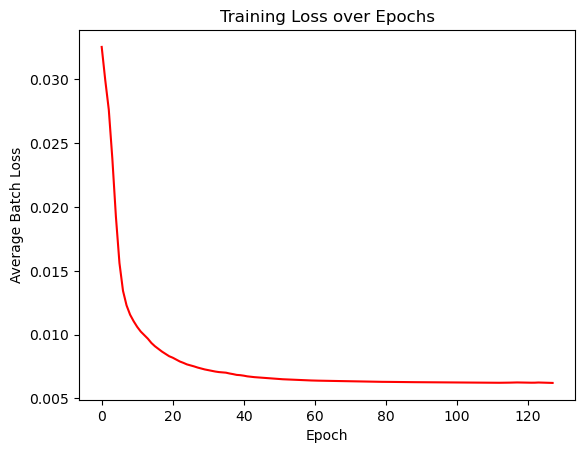

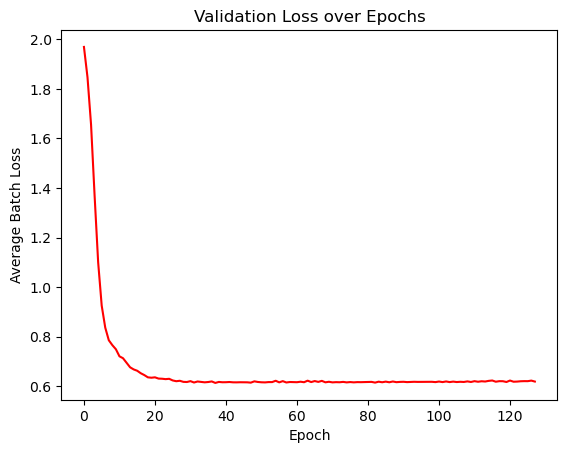

PART 7
Running Test Loop
batch: 1
original:


predicted:


difference:



batch: 2
original:


predicted:


difference:



batch: 3
original:


predicted:


difference:



batch: 4
original:


predicted:


difference:



Avg batch loss: 0.154681
Avg batch PSNR: 13.995743
Avg batch SSIM: 0.437313

TRAINING RECONSRTUCTION MODEL FOR: 0p5tfv40by40and240m

PART 1
PART 2
PART 3
ImgReconstructNN(
  (reconstruct_stack): Sequential(
    (0): Linear(in_features=300, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=4096, out_features=12544, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 112, 112))
    (7): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(4, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Sigmoid()
  )
)
PART 4
PART 5
-------------------------------
Epoch 1
Avg batch loss: 0.440834
-------------------------------
Epoch

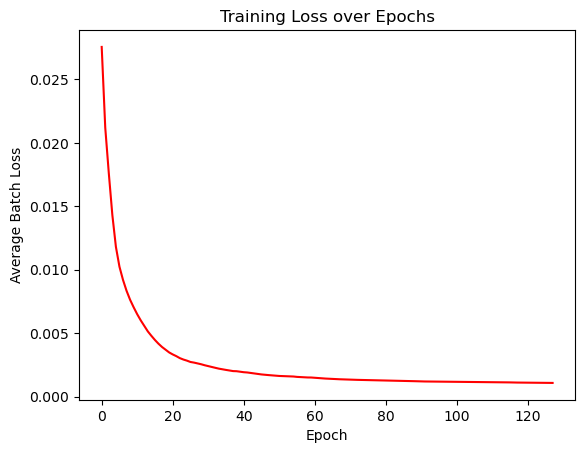

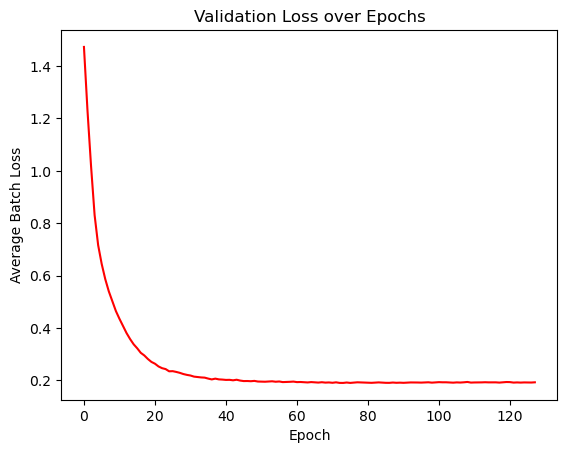

PART 7
Running Test Loop
batch: 1
original:


predicted:


difference:



batch: 2
original:


predicted:


difference:



batch: 3
original:


predicted:


difference:



batch: 4
original:


predicted:


difference:



Avg batch loss: 0.048099
Avg batch PSNR: 18.883787
Avg batch SSIM: 0.841561

TRAINING RECONSRTUCTION MODEL FOR: 100tfv40by40and240m

PART 1
PART 2
PART 3
ImgReconstructNN(
  (reconstruct_stack): Sequential(
    (0): Linear(in_features=300, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=4096, out_features=12544, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 112, 112))
    (7): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(4, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Sigmoid()
  )
)
PART 4
PART 5
-------------------------------
Epoch 1
Avg batch loss: 0.501484
-------------------------------
Epoch

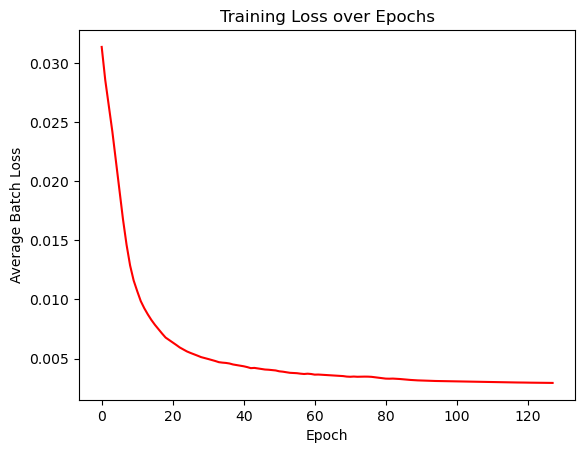

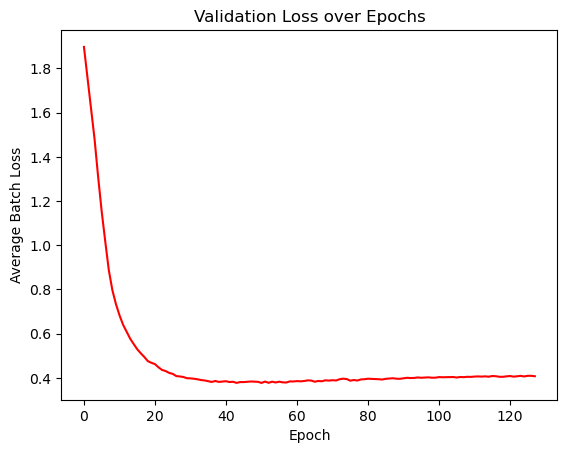

PART 7
Running Test Loop
batch: 1
original:


predicted:


difference:



batch: 2
original:


predicted:


difference:



batch: 3
original:


predicted:


difference:



batch: 4
original:


predicted:


difference:



Avg batch loss: 0.101870
Avg batch PSNR: 15.455772
Avg batch SSIM: 0.642469

TRAINING RECONSRTUCTION MODEL FOR: 10tfv40by40and240m

PART 1
PART 2
PART 3
ImgReconstructNN(
  (reconstruct_stack): Sequential(
    (0): Linear(in_features=300, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=4096, out_features=12544, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 112, 112))
    (7): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(4, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Sigmoid()
  )
)
PART 4
PART 5
-------------------------------
Epoch 1
Avg batch loss: 0.508616
-------------------------------
Epoch 

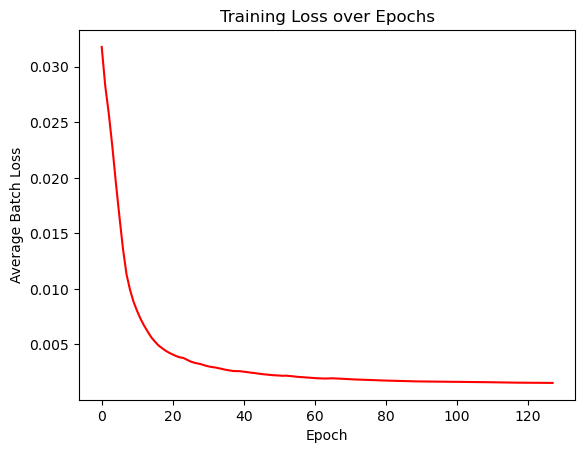

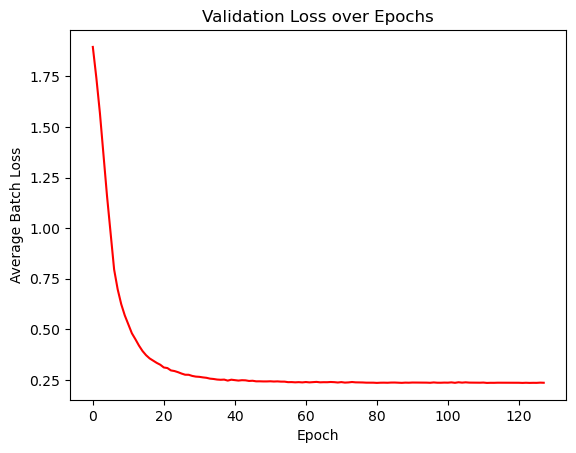

PART 7
Running Test Loop
batch: 1
original:


predicted:


difference:



batch: 2
original:


predicted:


difference:



batch: 3
original:


predicted:


difference:



batch: 4
original:


predicted:


difference:



Avg batch loss: 0.059027
Avg batch PSNR: 18.116289
Avg batch SSIM: 0.817681

TRAINING RECONSRTUCTION MODEL FOR: 1tfv40by40and240m

PART 1
PART 2
PART 3
ImgReconstructNN(
  (reconstruct_stack): Sequential(
    (0): Linear(in_features=300, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=4096, out_features=12544, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 112, 112))
    (7): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(4, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Sigmoid()
  )
)
PART 4
PART 5
-------------------------------
Epoch 1
Avg batch loss: 0.469948
-------------------------------
Epoch 8

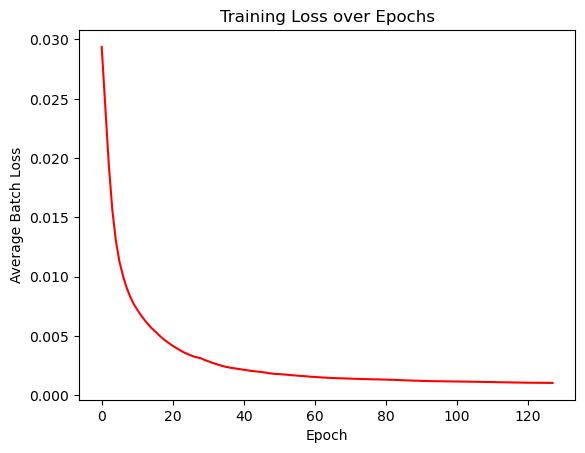

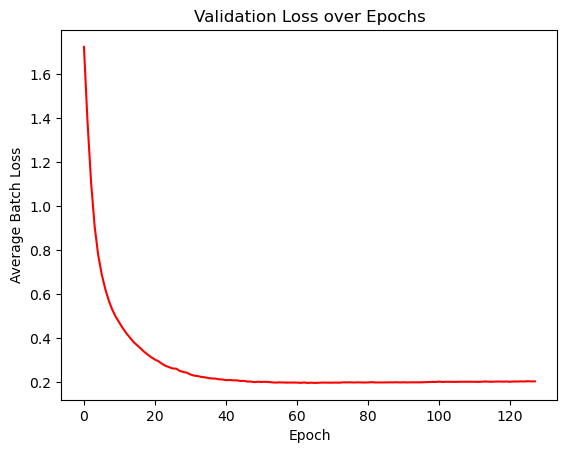

PART 7
Running Test Loop
batch: 1
original:


predicted:


difference:



batch: 2
original:


predicted:


difference:



batch: 3
original:


predicted:


difference:



batch: 4
original:


predicted:


difference:



Avg batch loss: 0.050791
Avg batch PSNR: 18.763133
Avg batch SSIM: 0.832398

TRAINING RECONSRTUCTION MODEL FOR: 200tfv40by40and240m

PART 1
PART 2
PART 3
ImgReconstructNN(
  (reconstruct_stack): Sequential(
    (0): Linear(in_features=300, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=4096, out_features=12544, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 112, 112))
    (7): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(4, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Sigmoid()
  )
)
PART 4
PART 5
-------------------------------
Epoch 1
Avg batch loss: 0.546995
-------------------------------
Epoch

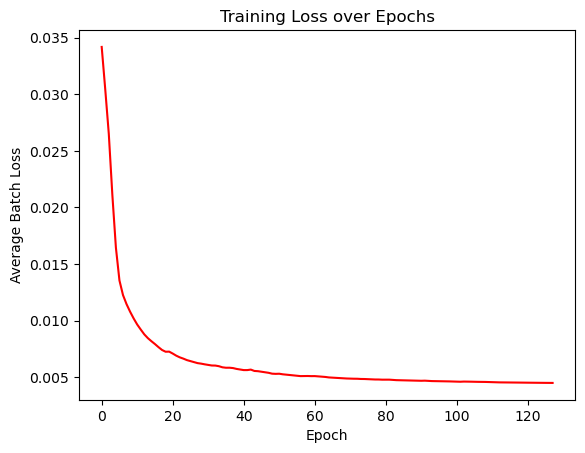

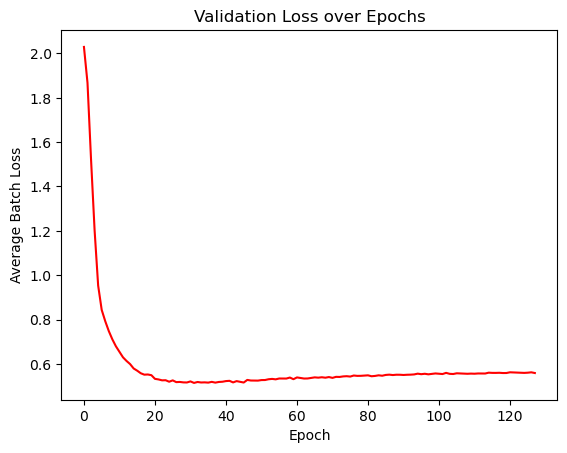

PART 7
Running Test Loop
batch: 1
original:


predicted:


difference:



batch: 2
original:


predicted:


difference:



batch: 3
original:


predicted:


difference:



batch: 4
original:


predicted:


difference:



Avg batch loss: 0.139636
Avg batch PSNR: 14.266428
Avg batch SSIM: 0.510987

TRAINING RECONSRTUCTION MODEL FOR: 20tfv40by40and240m

PART 1
PART 2
PART 3
ImgReconstructNN(
  (reconstruct_stack): Sequential(
    (0): Linear(in_features=300, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=4096, out_features=12544, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 112, 112))
    (7): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(4, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Sigmoid()
  )
)
PART 4
PART 5
-------------------------------
Epoch 1
Avg batch loss: 0.476990
-------------------------------
Epoch 

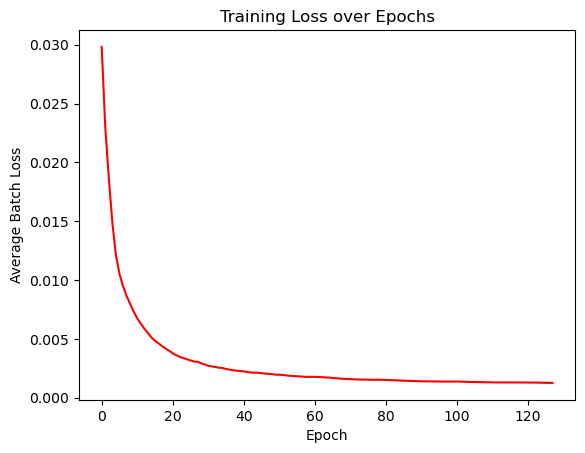

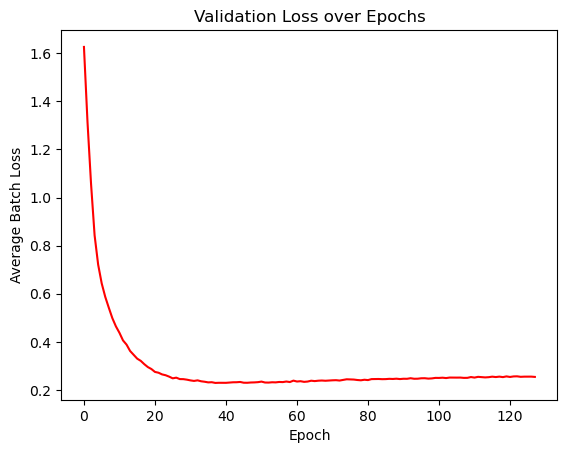

PART 7
Running Test Loop
batch: 1
original:


predicted:


difference:



batch: 2
original:


predicted:


difference:



batch: 3
original:


predicted:


difference:



batch: 4
original:


predicted:


difference:



Avg batch loss: 0.063496
Avg batch PSNR: 17.798902
Avg batch SSIM: 0.786974

TRAINING RECONSRTUCTION MODEL FOR: 2tfv40by40and240m

PART 1
PART 2
PART 3
ImgReconstructNN(
  (reconstruct_stack): Sequential(
    (0): Linear(in_features=300, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=4096, out_features=12544, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 112, 112))
    (7): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(4, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Sigmoid()
  )
)
PART 4
PART 5
-------------------------------
Epoch 1
Avg batch loss: 0.400023
-------------------------------
Epoch 8

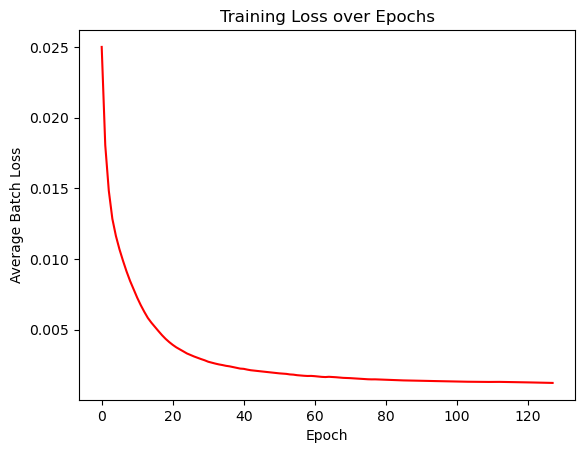

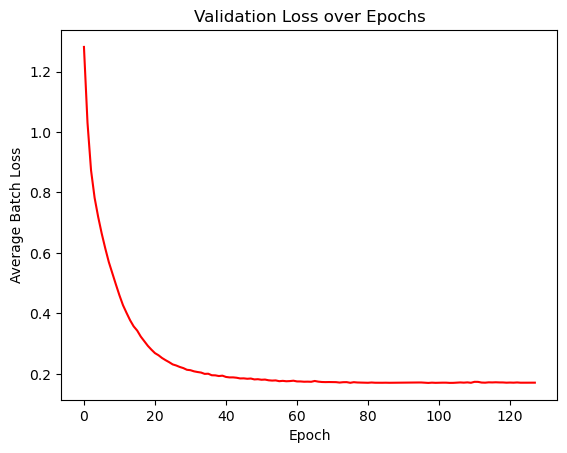

PART 7
Running Test Loop
batch: 1
original:


predicted:


difference:



batch: 2
original:


predicted:


difference:



batch: 3
original:


predicted:


difference:



batch: 4
original:


predicted:


difference:



Avg batch loss: 0.042759
Avg batch PSNR: 19.490871
Avg batch SSIM: 0.858258

TRAINING RECONSRTUCTION MODEL FOR: 50tfv40by40and240m

PART 1
PART 2
PART 3
ImgReconstructNN(
  (reconstruct_stack): Sequential(
    (0): Linear(in_features=300, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=4096, out_features=12544, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 112, 112))
    (7): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(4, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Sigmoid()
  )
)
PART 4
PART 5
-------------------------------
Epoch 1
Avg batch loss: 0.498316
-------------------------------
Epoch 

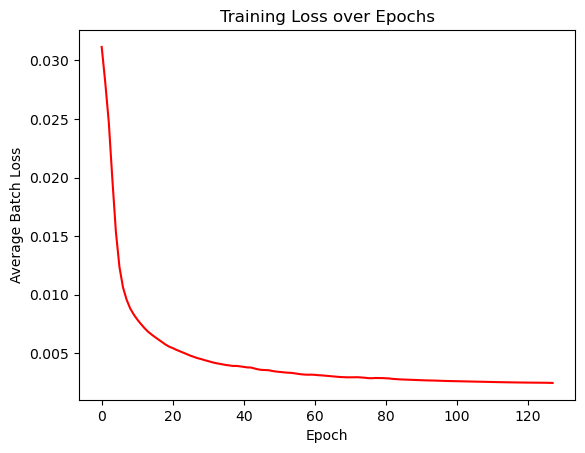

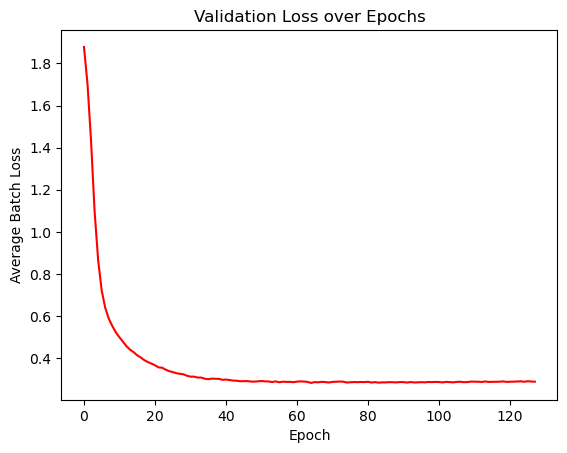

PART 7
Running Test Loop
batch: 1
original:


predicted:


difference:



batch: 2
original:


predicted:


difference:



batch: 3
original:


predicted:


difference:



batch: 4
original:


predicted:


difference:



Avg batch loss: 0.072086
Avg batch PSNR: 17.128857
Avg batch SSIM: 0.747705

TRAINING RECONSRTUCTION MODEL FOR: 5tfv40by40and240m

PART 1
PART 2
PART 3
ImgReconstructNN(
  (reconstruct_stack): Sequential(
    (0): Linear(in_features=300, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=4096, out_features=12544, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 112, 112))
    (7): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(4, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Sigmoid()
  )
)
PART 4
PART 5
-------------------------------
Epoch 1
Avg batch loss: 0.529854
-------------------------------
Epoch 8

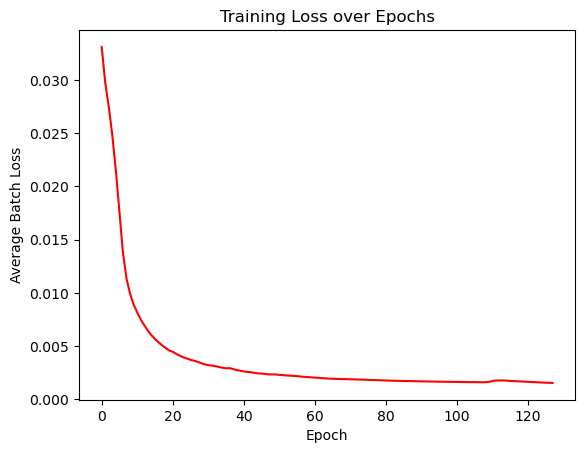

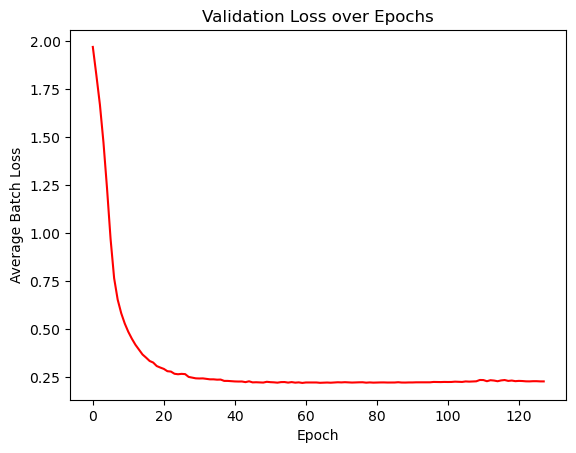

PART 7
Running Test Loop
batch: 1
original:


predicted:


difference:



batch: 2
original:


predicted:


difference:



batch: 3
original:


predicted:


difference:



batch: 4
original:


predicted:


difference:



Avg batch loss: 0.057369
Avg batch PSNR: 18.415976
Avg batch SSIM: 0.809779

TRAINING RECONSRTUCTION MODEL FOR: nnfv40by40and240m

PART 1
PART 2
PART 3
ImgReconstructNN(
  (reconstruct_stack): Sequential(
    (0): Linear(in_features=300, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=4096, out_features=12544, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 112, 112))
    (7): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(4, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Sigmoid()
  )
)
PART 4
PART 5
-------------------------------
Epoch 1
Avg batch loss: 0.530876
-------------------------------
Epoch 8

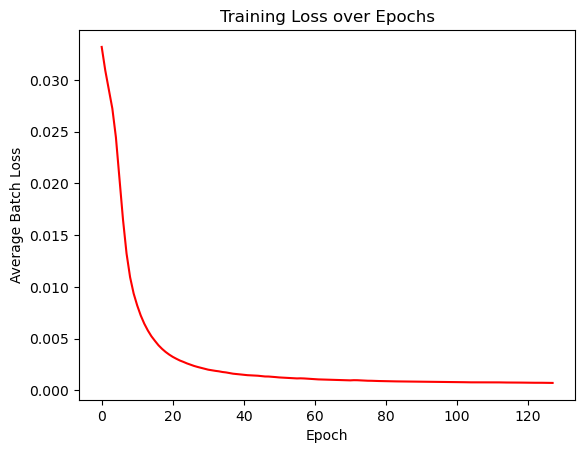

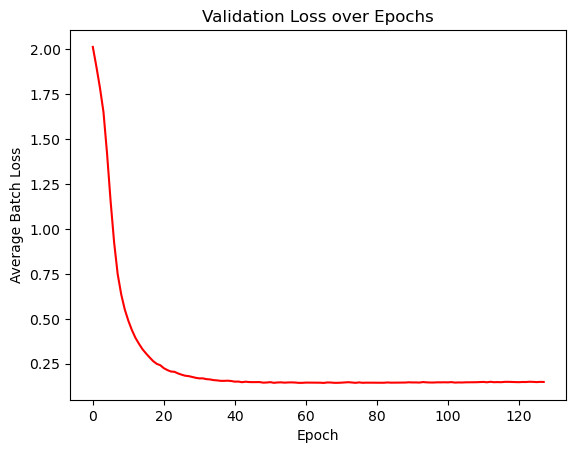

PART 7
Running Test Loop
batch: 1
original:


predicted:


difference:



batch: 2
original:


predicted:


difference:



batch: 3
original:


predicted:


difference:



batch: 4
original:


predicted:


difference:



Avg batch loss: 0.037181
Avg batch PSNR: 20.372601
Avg batch SSIM: 0.878462

TRAINING RECONSRTUCTION MODEL FOR: 100n40by40and240m

PART 1
PART 2
PART 3
ImgReconstructNN(
  (reconstruct_stack): Sequential(
    (0): Linear(in_features=300, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=4096, out_features=12544, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 112, 112))
    (7): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(4, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Sigmoid()
  )
)
PART 4
PART 5
-------------------------------
Epoch 1
Avg batch loss: 0.475374
-------------------------------
Epoch 8

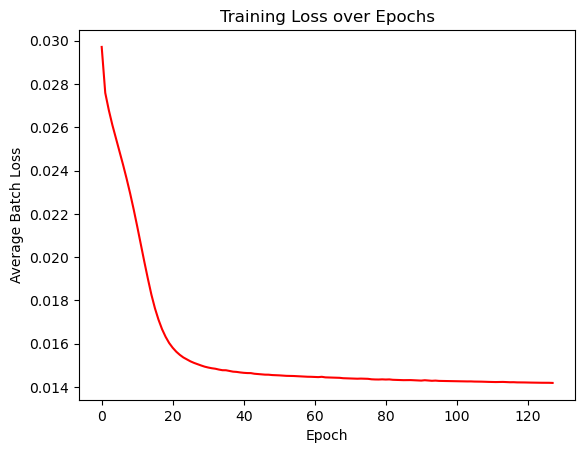

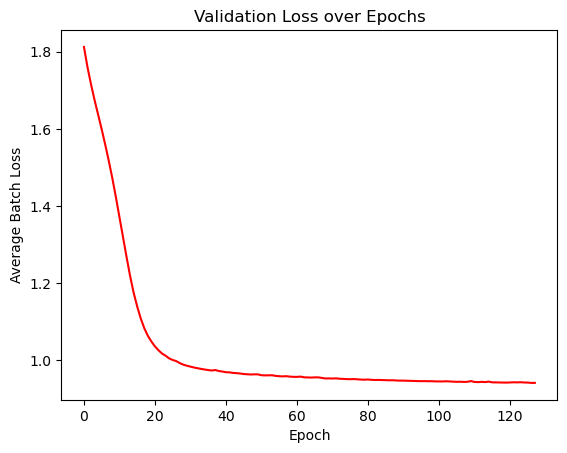

PART 7
Running Test Loop
batch: 1
original:


predicted:


difference:



batch: 2
original:


predicted:


difference:



batch: 3
original:


predicted:


difference:



batch: 4
original:


predicted:


difference:



Avg batch loss: 0.235419
Avg batch PSNR: 12.989505
Avg batch SSIM: 0.184941

TRAINING RECONSRTUCTION MODEL FOR: 37n40by40and240m

PART 1
PART 2
PART 3
ImgReconstructNN(
  (reconstruct_stack): Sequential(
    (0): Linear(in_features=300, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=4096, out_features=12544, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 112, 112))
    (7): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(4, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Sigmoid()
  )
)
PART 4
PART 5
-------------------------------
Epoch 1
Avg batch loss: 0.509529
-------------------------------
Epoch 8


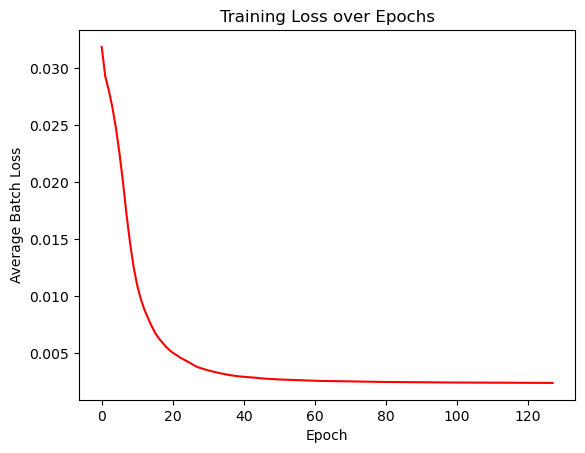

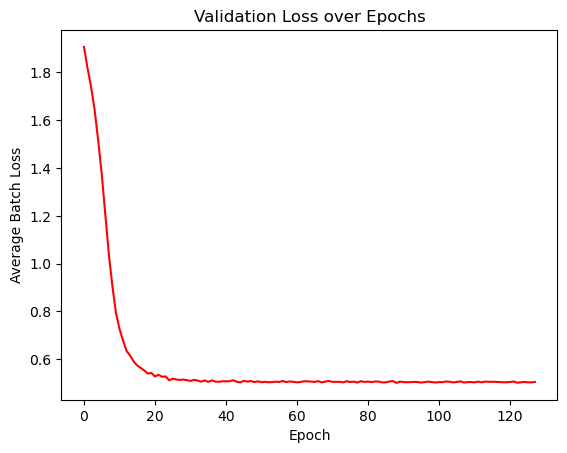

PART 7
Running Test Loop
batch: 1
original:


predicted:


difference:



batch: 2
original:


predicted:


difference:



batch: 3
original:


predicted:


difference:



batch: 4
original:


predicted:


difference:



Avg batch loss: 0.126038
Avg batch PSNR: 14.711844
Avg batch SSIM: 0.528981

TRAINING RECONSRTUCTION MODEL FOR: 50n40by40and240m

PART 1
PART 2
PART 3
ImgReconstructNN(
  (reconstruct_stack): Sequential(
    (0): Linear(in_features=300, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=4096, out_features=12544, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 112, 112))
    (7): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(4, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Sigmoid()
  )
)
PART 4
PART 5
-------------------------------
Epoch 1
Avg batch loss: 0.429199
-------------------------------
Epoch 8


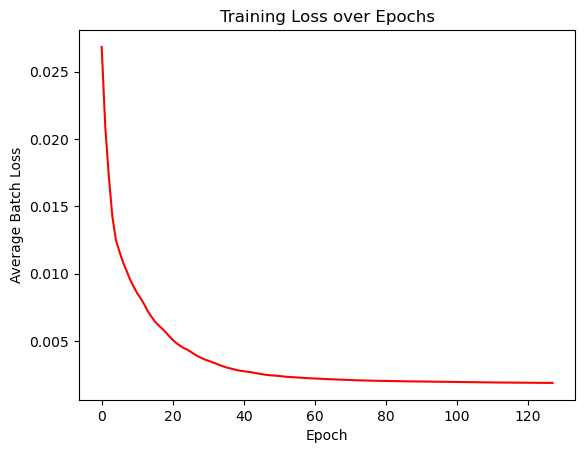

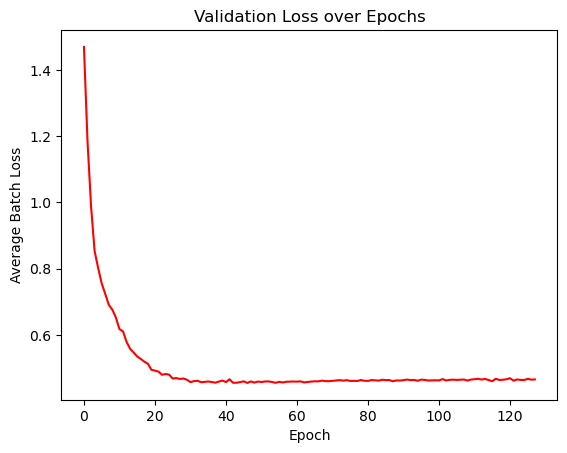

PART 7
Running Test Loop
batch: 1
original:


predicted:


difference:



batch: 2
original:


predicted:


difference:



batch: 3
original:


predicted:


difference:



batch: 4
original:


predicted:


difference:



Avg batch loss: 0.116289
Avg batch PSNR: 15.049157
Avg batch SSIM: 0.578430

TRAINING RECONSRTUCTION MODEL FOR: 62n40by40and240m

PART 1
PART 2
PART 3
ImgReconstructNN(
  (reconstruct_stack): Sequential(
    (0): Linear(in_features=300, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=4096, out_features=12544, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 112, 112))
    (7): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(4, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Sigmoid()
  )
)
PART 4
PART 5
-------------------------------
Epoch 1
Avg batch loss: 0.502756
-------------------------------
Epoch 8


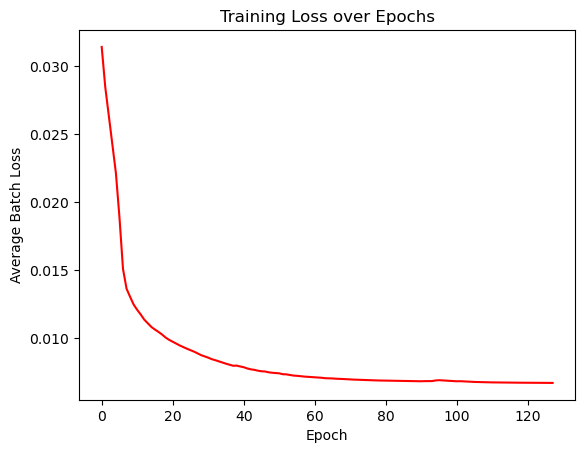

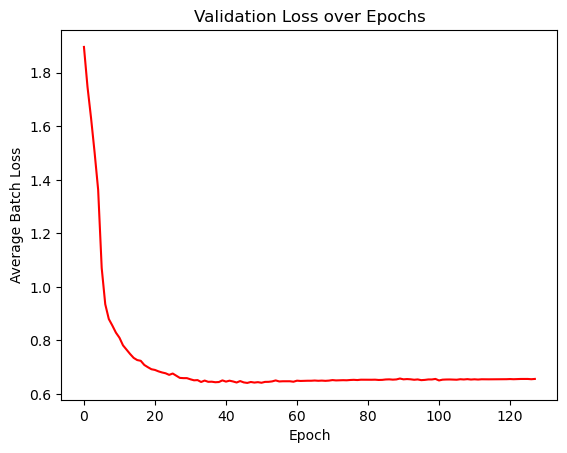

PART 7
Running Test Loop
batch: 1
original:


predicted:


difference:



batch: 2
original:


predicted:


difference:



batch: 3
original:


predicted:


difference:



batch: 4
original:


predicted:


difference:



Avg batch loss: 0.164085
Avg batch PSNR: 13.683954
Avg batch SSIM: 0.409818

TRAINING RECONSRTUCTION MODEL FOR: 75n40by40and240m

PART 1
PART 2
PART 3
ImgReconstructNN(
  (reconstruct_stack): Sequential(
    (0): Linear(in_features=300, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=4096, out_features=12544, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 112, 112))
    (7): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(4, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Sigmoid()
  )
)
PART 4
PART 5
-------------------------------
Epoch 1
Avg batch loss: 0.483442
-------------------------------
Epoch 8


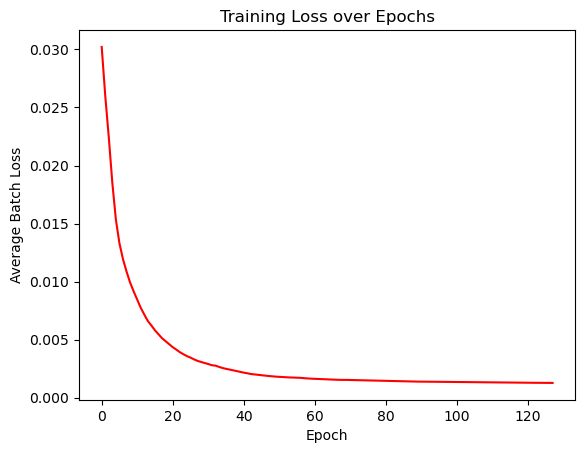

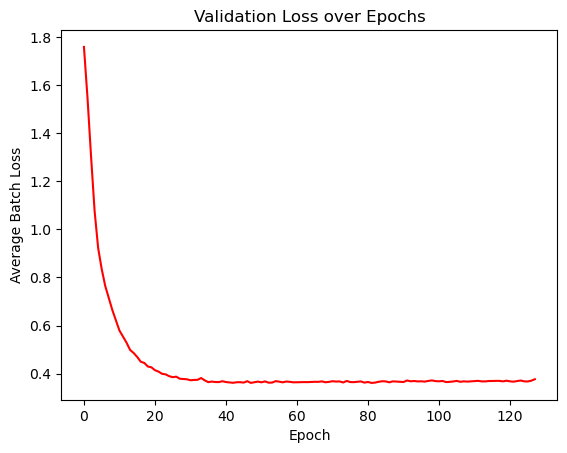

PART 7
Running Test Loop
batch: 1
original:


predicted:


difference:



batch: 2
original:


predicted:


difference:



batch: 3
original:


predicted:


difference:



batch: 4
original:


predicted:


difference:



Avg batch loss: 0.094261
Avg batch PSNR: 16.177523
Avg batch SSIM: 0.660881

TRAINING RECONSRTUCTION MODEL FOR: 87p5n40by40and240m

PART 1
PART 2
PART 3
ImgReconstructNN(
  (reconstruct_stack): Sequential(
    (0): Linear(in_features=300, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=4096, out_features=12544, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 112, 112))
    (7): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(4, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Sigmoid()
  )
)
PART 4
PART 5
-------------------------------
Epoch 1
Avg batch loss: 0.485300
-------------------------------
Epoch 

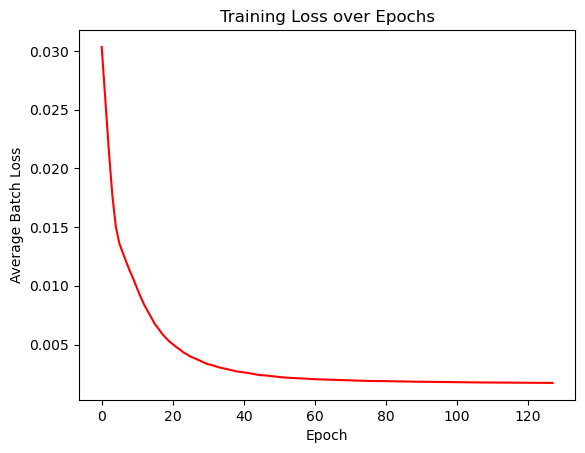

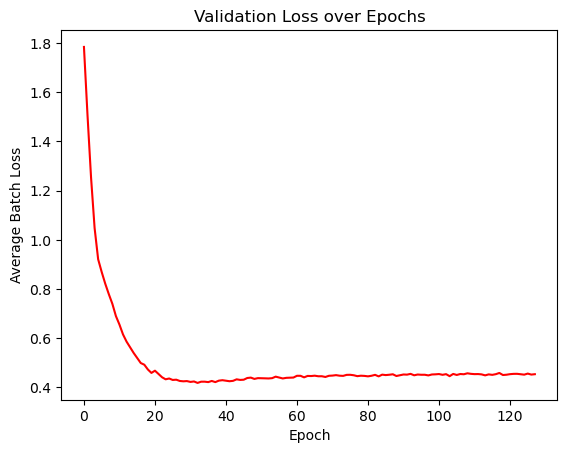

PART 7
Running Test Loop
batch: 1
original:


predicted:


difference:



batch: 2
original:


predicted:


difference:



batch: 3
original:


predicted:


difference:



batch: 4
original:


predicted:


difference:



Avg batch loss: 0.113454
Avg batch PSNR: 15.419546
Avg batch SSIM: 0.605150

TRAINING RECONSRTUCTION MODEL FOR: a25n40by40and240m

PART 1
PART 2
PART 3
ImgReconstructNN(
  (reconstruct_stack): Sequential(
    (0): Linear(in_features=300, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=4096, out_features=12544, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 112, 112))
    (7): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(4, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Sigmoid()
  )
)
PART 4
PART 5
-------------------------------
Epoch 1
Avg batch loss: 0.477322
-------------------------------
Epoch 8

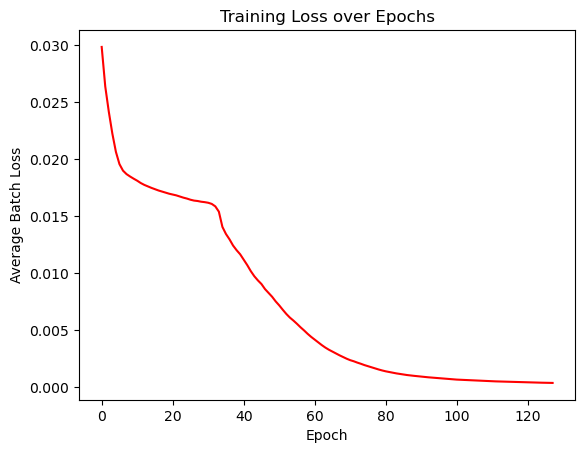

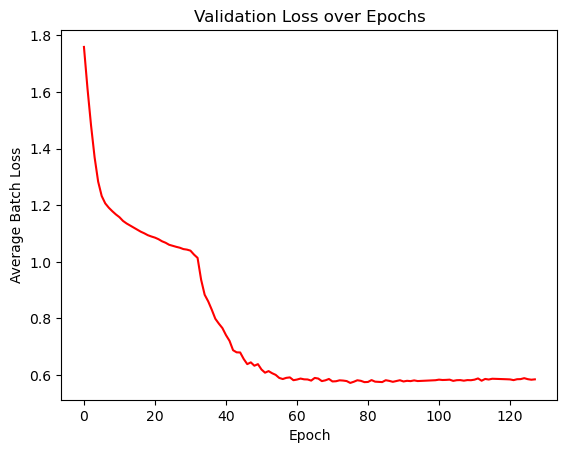

PART 7
Running Test Loop
batch: 1
original:


predicted:


difference:



batch: 2
original:


predicted:


difference:



batch: 3
original:


predicted:


difference:



batch: 4
original:


predicted:


difference:



Avg batch loss: 0.146125
Avg batch PSNR: 14.462722
Avg batch SSIM: 0.457641

TRAINING RECONSRTUCTION MODEL FOR: 10fv40by40and240m

PART 1
PART 2
PART 3
ImgReconstructNN(
  (reconstruct_stack): Sequential(
    (0): Linear(in_features=300, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=4096, out_features=12544, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 112, 112))
    (7): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(4, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Sigmoid()
  )
)
PART 4
PART 5
-------------------------------
Epoch 1
Avg batch loss: 0.482553
-------------------------------
Epoch 8

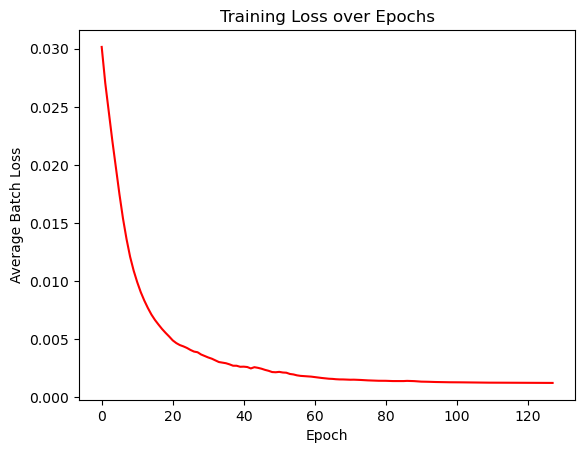

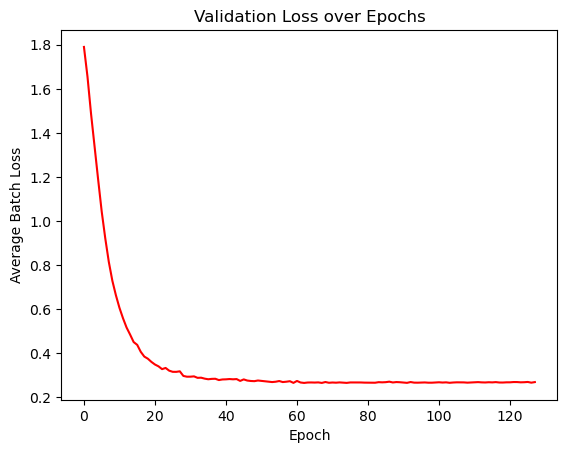

PART 7
Running Test Loop
batch: 1
original:


predicted:


difference:



batch: 2
original:


predicted:


difference:



batch: 3
original:


predicted:


difference:



batch: 4
original:


predicted:


difference:



Avg batch loss: 0.067176
Avg batch PSNR: 17.495289
Avg batch SSIM: 0.768049

TRAINING RECONSRTUCTION MODEL FOR: 3fv40by40and240m

PART 1
PART 2
PART 3
ImgReconstructNN(
  (reconstruct_stack): Sequential(
    (0): Linear(in_features=300, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=4096, out_features=12544, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 112, 112))
    (7): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(4, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Sigmoid()
  )
)
PART 4
PART 5
-------------------------------
Epoch 1
Avg batch loss: 0.498941
-------------------------------
Epoch 8


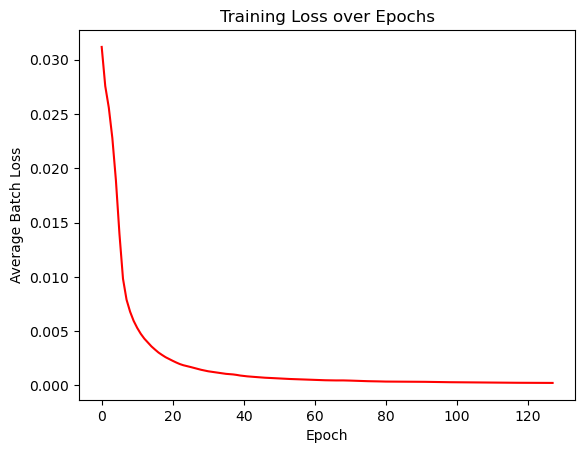

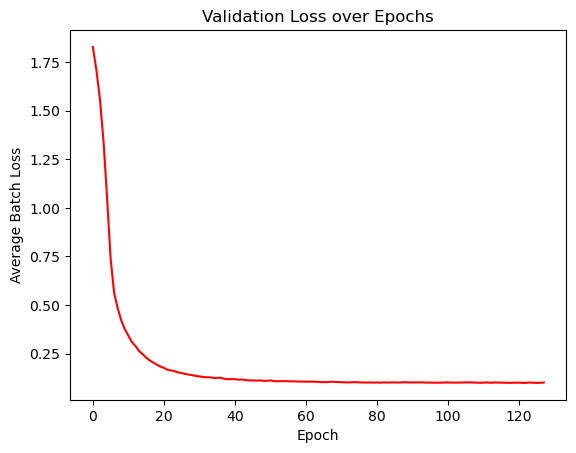

PART 7
Running Test Loop
batch: 1
original:


predicted:


difference:



batch: 2
original:


predicted:


difference:



batch: 3
original:


predicted:


difference:



batch: 4
original:


predicted:


difference:



Avg batch loss: 0.025431
Avg batch PSNR: 22.505496
Avg batch SSIM: 0.913711

TRAINING RECONSRTUCTION MODEL FOR: 7a5fv40by40and240m

PART 1
PART 2
PART 3
ImgReconstructNN(
  (reconstruct_stack): Sequential(
    (0): Linear(in_features=300, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=4096, out_features=12544, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 112, 112))
    (7): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(4, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Sigmoid()
  )
)
PART 4
PART 5
-------------------------------
Epoch 1
Avg batch loss: 0.511249
-------------------------------
Epoch 

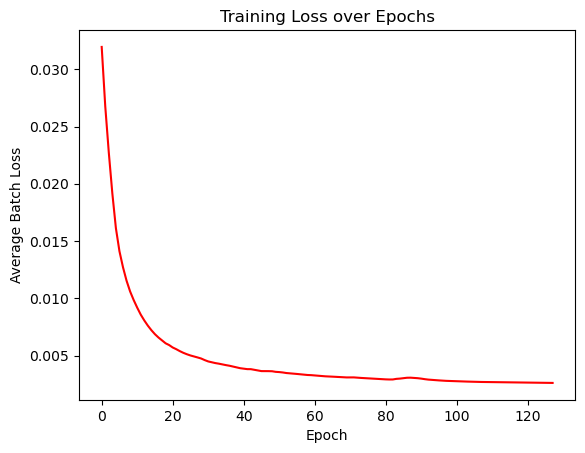

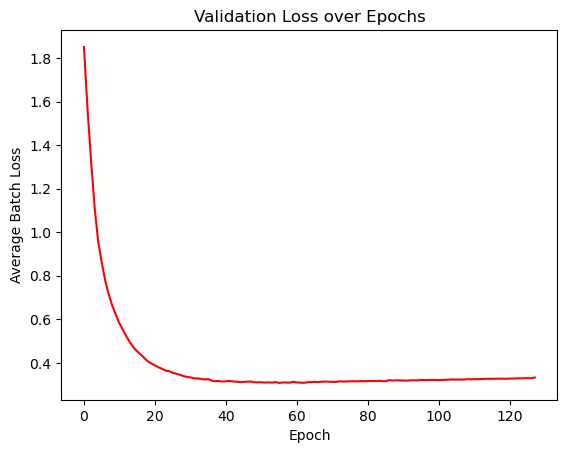

PART 7
Running Test Loop
batch: 1
original:


predicted:


difference:



batch: 2
original:


predicted:


difference:



batch: 3
original:


predicted:


difference:



batch: 4
original:


predicted:


difference:



Avg batch loss: 0.083154
Avg batch PSNR: 16.366408
Avg batch SSIM: 0.719745

TRAINING RECONSRTUCTION MODEL FOR: aa15fv40by40and240m

PART 1
PART 2
PART 3
ImgReconstructNN(
  (reconstruct_stack): Sequential(
    (0): Linear(in_features=300, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=4096, out_features=12544, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 112, 112))
    (7): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(4, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Sigmoid()
  )
)
PART 4
PART 5
-------------------------------
Epoch 1
Avg batch loss: 0.477429
-------------------------------
Epoch

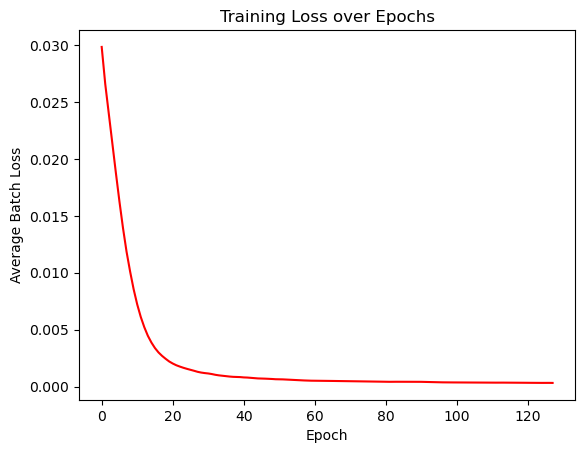

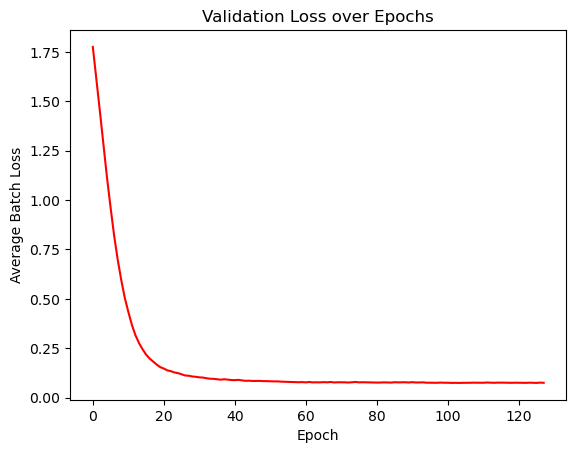

PART 7
Running Test Loop
batch: 1
original:


predicted:


difference:



batch: 2
original:


predicted:


difference:



batch: 3
original:


predicted:


difference:



batch: 4
original:


predicted:


difference:



Avg batch loss: 0.018739
Avg batch PSNR: 24.085021
Avg batch SSIM: 0.943550

TRAINING RECONSRTUCTION MODEL FOR: aa20fv40by40and240m

PART 1
PART 2
PART 3
ImgReconstructNN(
  (reconstruct_stack): Sequential(
    (0): Linear(in_features=300, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=4096, out_features=12544, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 112, 112))
    (7): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(4, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Sigmoid()
  )
)
PART 4
PART 5
-------------------------------
Epoch 1
Avg batch loss: 0.520923
-------------------------------
Epoch

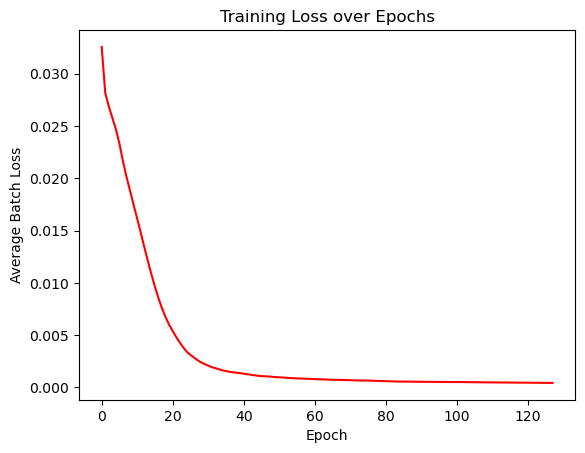

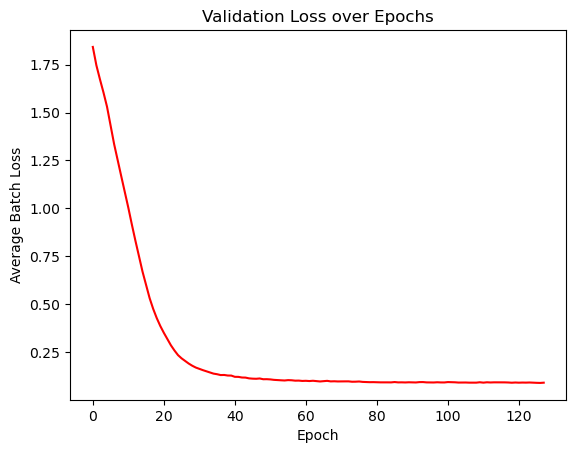

PART 7
Running Test Loop
batch: 1
original:


predicted:


difference:



batch: 2
original:


predicted:


difference:



batch: 3
original:


predicted:


difference:



batch: 4
original:


predicted:


difference:



Avg batch loss: 0.022302
Avg batch PSNR: 23.141202
Avg batch SSIM: 0.924981

TRAINING RECONSRTUCTION MODEL FOR: aa25fv40by40and240m

PART 1
PART 2
PART 3
ImgReconstructNN(
  (reconstruct_stack): Sequential(
    (0): Linear(in_features=300, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=4096, out_features=12544, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 112, 112))
    (7): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(4, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Sigmoid()
  )
)
PART 4
PART 5
-------------------------------
Epoch 1
Avg batch loss: 0.427971
-------------------------------
Epoch

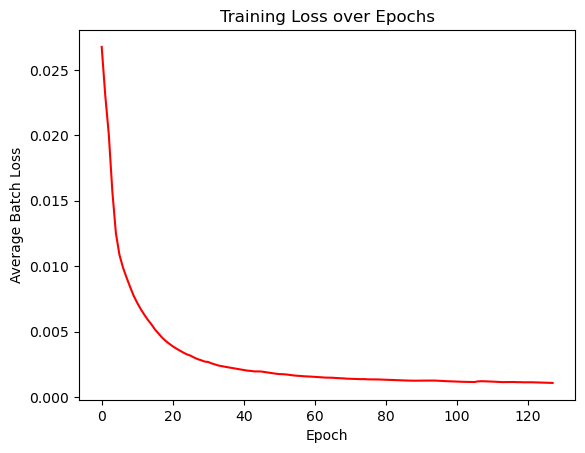

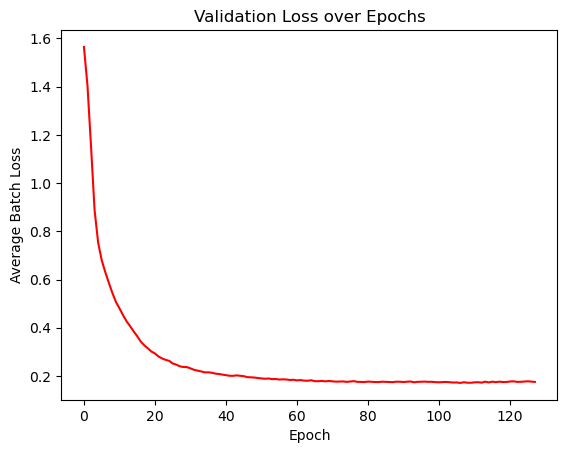

PART 7
Running Test Loop
batch: 1
original:


predicted:


difference:



batch: 2
original:


predicted:


difference:



batch: 3
original:


predicted:


difference:



batch: 4
original:


predicted:


difference:



Avg batch loss: 0.043866
Avg batch PSNR: 19.611859
Avg batch SSIM: 0.859398

TRAINING RECONSRTUCTION MODEL FOR: aa30fv40by40and240m

PART 1
PART 2
PART 3
ImgReconstructNN(
  (reconstruct_stack): Sequential(
    (0): Linear(in_features=300, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=4096, out_features=12544, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 112, 112))
    (7): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(4, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Sigmoid()
  )
)
PART 4
PART 5
-------------------------------
Epoch 1
Avg batch loss: 0.424425
-------------------------------
Epoch

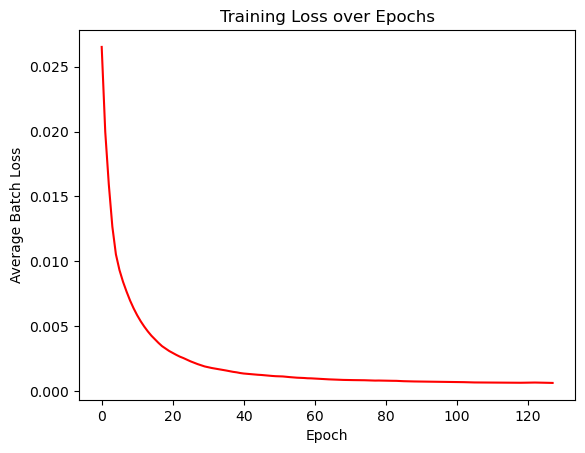

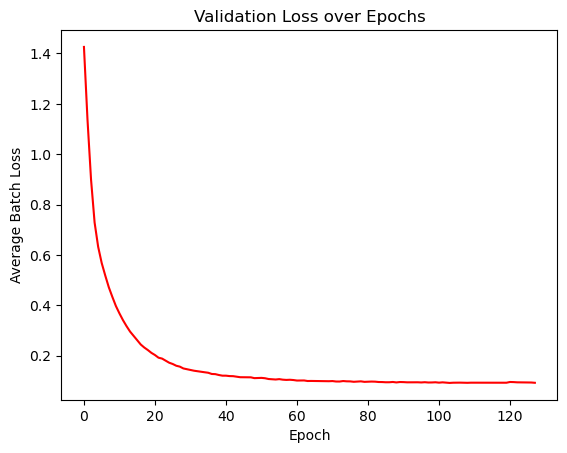

PART 7
Running Test Loop
batch: 1
original:


predicted:


difference:



batch: 2
original:


predicted:


difference:



batch: 3
original:


predicted:


difference:



batch: 4
original:


predicted:


difference:



Avg batch loss: 0.023050
Avg batch PSNR: 22.668339
Avg batch SSIM: 0.921670

TRAINING RECONSRTUCTION MODEL FOR: aa35fv40by40and240m

PART 1
PART 2
PART 3
ImgReconstructNN(
  (reconstruct_stack): Sequential(
    (0): Linear(in_features=300, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=4096, out_features=12544, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 112, 112))
    (7): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(4, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Sigmoid()
  )
)
PART 4
PART 5
-------------------------------
Epoch 1
Avg batch loss: 0.458934
-------------------------------
Epoch

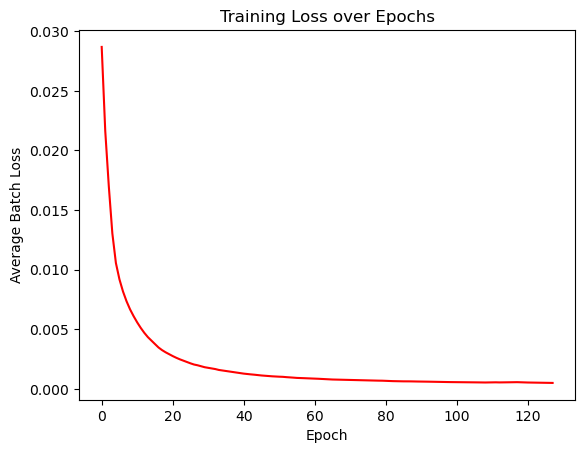

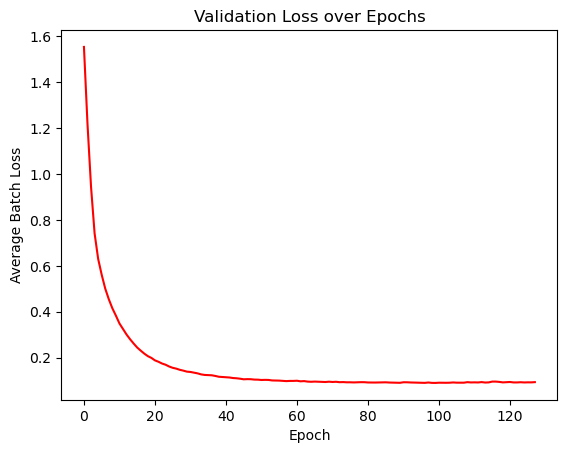

PART 7
Running Test Loop
batch: 1
original:


predicted:


difference:



batch: 2
original:


predicted:


difference:



batch: 3
original:


predicted:


difference:



batch: 4
original:


predicted:


difference:



Avg batch loss: 0.023434
Avg batch PSNR: 22.718940
Avg batch SSIM: 0.920571

TRAINING RECONSRTUCTION MODEL FOR: aa40fv40by40and240m

PART 1
PART 2
PART 3
ImgReconstructNN(
  (reconstruct_stack): Sequential(
    (0): Linear(in_features=300, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=4096, out_features=12544, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 112, 112))
    (7): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(4, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Sigmoid()
  )
)
PART 4
PART 5
-------------------------------
Epoch 1
Avg batch loss: 0.480587
-------------------------------
Epoch

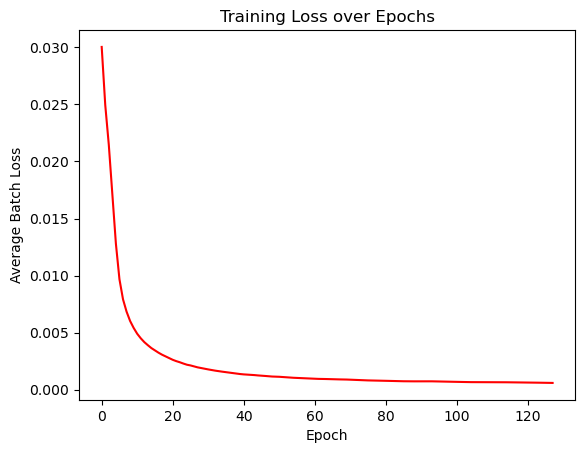

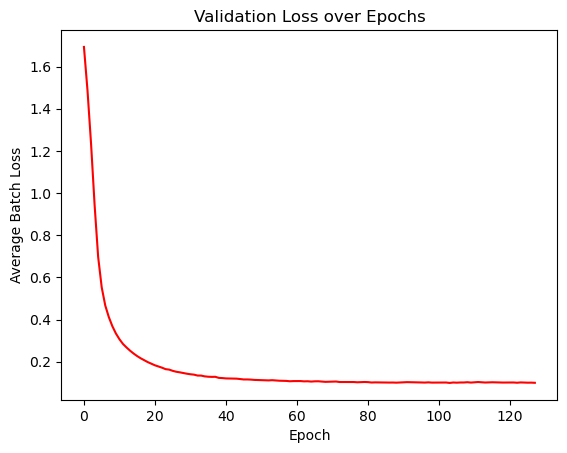

PART 7
Running Test Loop
batch: 1
original:


predicted:


difference:



batch: 2
original:


predicted:


difference:



batch: 3
original:


predicted:


difference:



batch: 4
original:


predicted:


difference:



Avg batch loss: 0.024964
Avg batch PSNR: 22.625689
Avg batch SSIM: 0.916317

TRAINING RECONSRTUCTION MODEL FOR: aa5fv40by40and240m

PART 1
PART 2
PART 3
ImgReconstructNN(
  (reconstruct_stack): Sequential(
    (0): Linear(in_features=300, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=4096, out_features=12544, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 112, 112))
    (7): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(4, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Sigmoid()
  )
)
PART 4
PART 5
-------------------------------
Epoch 1
Avg batch loss: 0.515322
-------------------------------
Epoch 

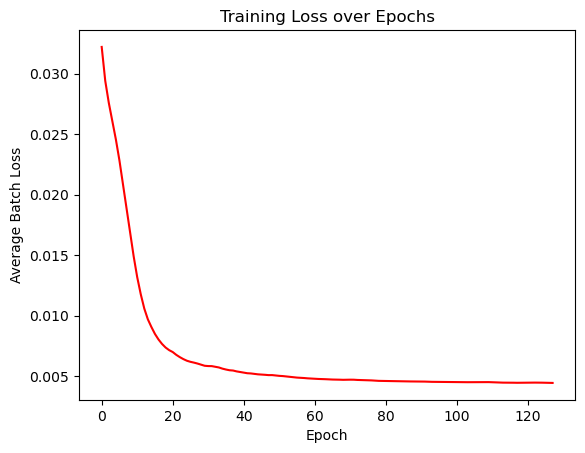

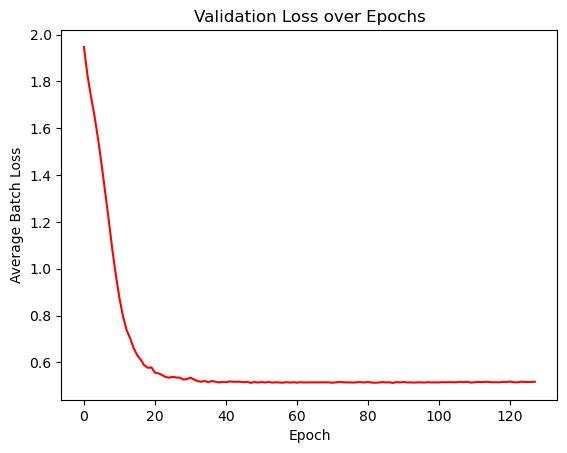

PART 7
Running Test Loop
batch: 1
original:


predicted:


difference:



batch: 2
original:


predicted:


difference:



batch: 3
original:


predicted:


difference:



batch: 4
original:


predicted:


difference:



Avg batch loss: 0.129222
Avg batch PSNR: 14.595334
Avg batch SSIM: 0.565256

TRAINING RECONSRTUCTION MODEL FOR: aa6fv40by40and240m

PART 1
PART 2
PART 3
ImgReconstructNN(
  (reconstruct_stack): Sequential(
    (0): Linear(in_features=300, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=4096, out_features=12544, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 112, 112))
    (7): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(4, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Sigmoid()
  )
)
PART 4
PART 5
-------------------------------
Epoch 1
Avg batch loss: 0.542262
-------------------------------
Epoch 

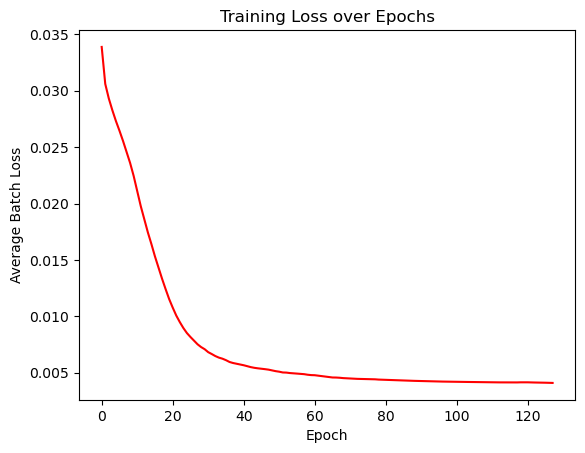

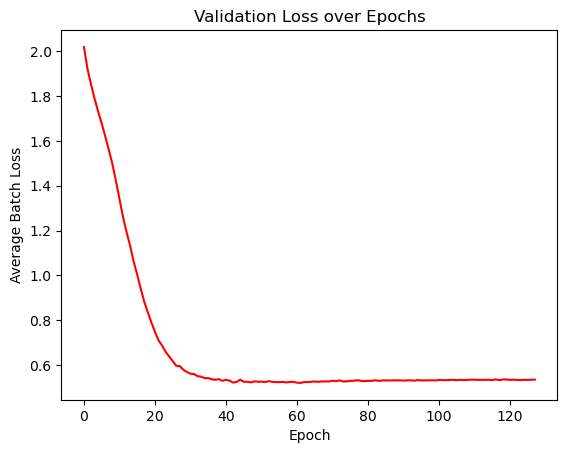

PART 7
Running Test Loop
batch: 1
original:


predicted:


difference:



batch: 2
original:


predicted:


difference:



batch: 3
original:


predicted:


difference:



batch: 4
original:


predicted:


difference:



Avg batch loss: 0.133721
Avg batch PSNR: 14.303417
Avg batch SSIM: 0.536033


In [4]:
# hyper parameters
batch_size = 50
val_size = 0.2
epochs = 128
learning_rate = 1e-3
loss_fn = L1_SSIM_loss(window_size=2, n_channels=1).to(device)

###############################################################################
# IMAGE RECONSTRUCTION
###############################################################################

# VARIED NOISE LEVELS
results = {}
results['detection_type'] = []
results['filename'] = []
results['val_loss'] = []
results['val_psnr'] = []
results['val_ssim'] = []
for filename in os.listdir(f'../data/features/ASE_noise/direct_detection'):
    val_loss, val_psnr, val_ssim = reconstruct("ASE_noise", "direct_detection", filename, batch_size, val_size, epochs, loss_fn, learning_rate)
    results['detection_type'].append("Direct Detection")
    results['filename'].append(filename)
    results['val_loss'].append(val_loss)
    results['val_psnr'].append(val_psnr)
    results['val_ssim'].append(val_ssim)
for filename in os.listdir(f'../data/features/ASE_noise/QPMS'):
    val_loss, val_psnr, val_ssim = reconstruct("ASE_noise", "QPMS", filename, batch_size, val_size, epochs, loss_fn, learning_rate)
    results['detection_type'].append("QPMS")
    results['filename'].append(filename)
    results['val_loss'].append(val_loss)
    results['val_psnr'].append(val_psnr)
    results['val_ssim'].append(val_ssim)
results = pd.DataFrame.from_dict(results)
filename = '../data/features/ASE_noise/reconstruction_results.csv'
results.to_csv(filename, index=False)


# VARIED INTEGRATION TIMES
results = {}
results['detection_type'] = []
results['filename'] = []
results['val_loss'] = []
results['val_psnr'] = []
results['val_ssim'] = []
for filename in os.listdir(f'../data/features/integration_time/direct_detection'):
    val_loss, val_psnr, val_ssim = reconstruct("integration_time", "direct_detection", filename, batch_size, val_size, epochs, loss_fn, learning_rate)
    results['detection_type'].append("Direct Detection")
    results['filename'].append(filename)
    results['val_loss'].append(val_loss)
    results['val_psnr'].append(val_psnr)
    results['val_ssim'].append(val_ssim)
for filename in os.listdir(f'../data/features/integration_time/QPMS'):
    val_loss, val_psnr, val_ssim = reconstruct("integration_time", "QPMS", filename, batch_size, val_size, epochs, loss_fn, learning_rate)
    results['detection_type'].append("QPMS")
    results['filename'].append(filename)
    results['val_loss'].append(val_loss)
    results['val_psnr'].append(val_psnr)
    results['val_ssim'].append(val_ssim)
results = pd.DataFrame.from_dict(results)
filename = '../data/features/integration_time/reconstruction_results.csv'
results.to_csv(filename, index=False)


TRAINING RECONSRTUCTION MODEL FOR: annd40by40and240m

PART 1
PART 2
PART 3
ImgReconstructNN(
  (reconstruct_stack): Sequential(
    (0): Linear(in_features=100, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=4096, out_features=12544, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 112, 112))
    (7): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(4, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Sigmoid()
  )
)
PART 4
PART 5
-------------------------------
Epoch 1
Avg batch loss: 0.447757
-------------------------------
Epoch 8
Avg batch loss: 0.213387
-------------------------------
Epoch 16
Avg batch 

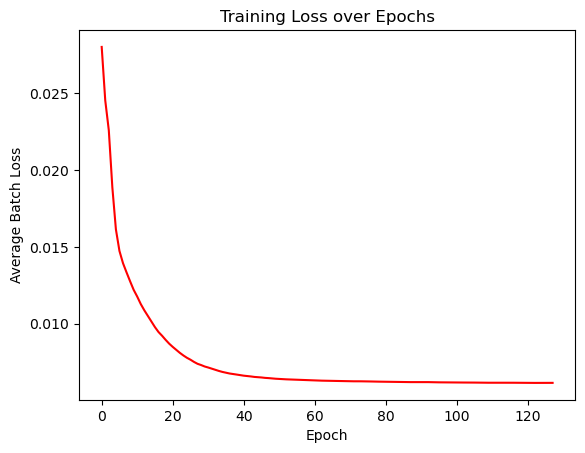

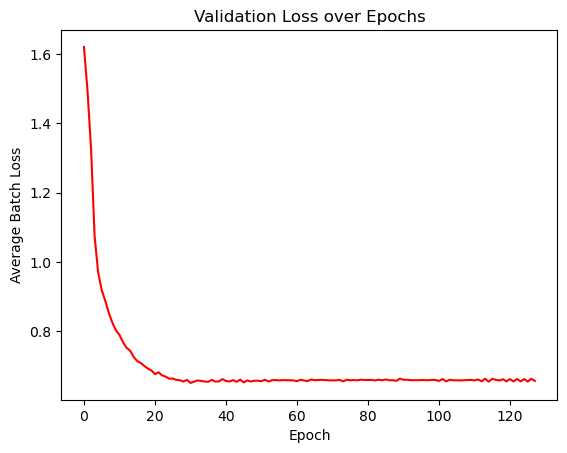

PART 7
Running Test Loop
batch: 1
original:


predicted:


difference:



batch: 2
original:


predicted:


difference:



batch: 3
original:


predicted:


difference:



batch: 4
original:


predicted:


difference:



Avg batch loss: 0.164177
Avg batch PSNR: 13.729235
Avg batch SSIM: 0.415418

TRAINING RECONSRTUCTION MODEL FOR: 0p5tfv40by40and240m

PART 1
PART 2
PART 3
ImgReconstructNN(
  (reconstruct_stack): Sequential(
    (0): Linear(in_features=100, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=4096, out_features=12544, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 112, 112))
    (7): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(4, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Sigmoid()
  )
)
PART 4
PART 5
-------------------------------
Epoch 1
Avg batch loss: 0.529596
-------------------------------
Epoch

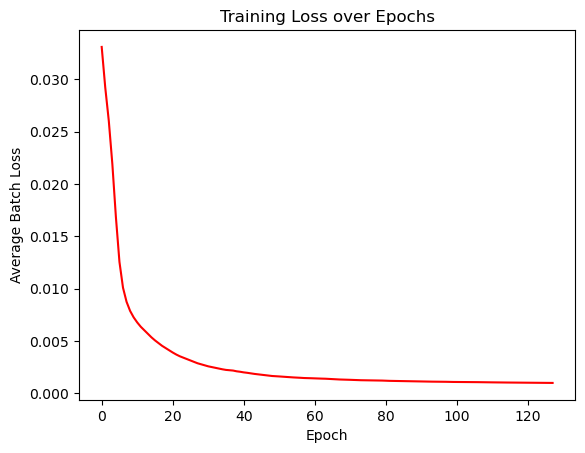

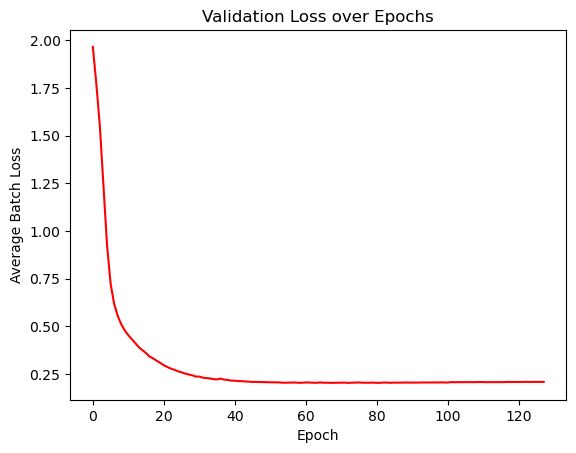

PART 7
Running Test Loop
batch: 1
original:


predicted:


difference:



batch: 2
original:


predicted:


difference:



batch: 3
original:


predicted:


difference:



batch: 4
original:


predicted:


difference:



Avg batch loss: 0.052093
Avg batch PSNR: 18.461478
Avg batch SSIM: 0.821828

TRAINING RECONSRTUCTION MODEL FOR: 100tfv40by40and240m

PART 1
PART 2
PART 3
ImgReconstructNN(
  (reconstruct_stack): Sequential(
    (0): Linear(in_features=100, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=4096, out_features=12544, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 112, 112))
    (7): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(4, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Sigmoid()
  )
)
PART 4
PART 5
-------------------------------
Epoch 1
Avg batch loss: 0.452434
-------------------------------
Epoch

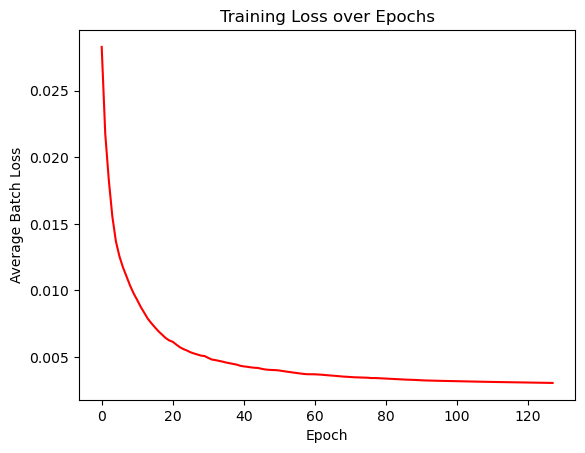

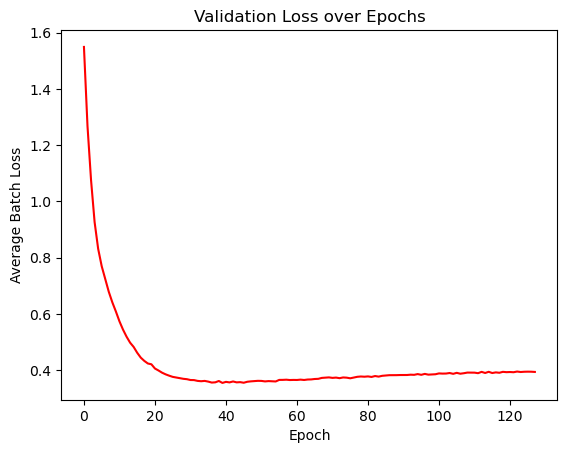

PART 7
Running Test Loop
batch: 1
original:


predicted:


difference:



batch: 2
original:


predicted:


difference:



batch: 3
original:


predicted:


difference:



batch: 4
original:


predicted:


difference:



Avg batch loss: 0.098502
Avg batch PSNR: 15.847622
Avg batch SSIM: 0.658326

TRAINING RECONSRTUCTION MODEL FOR: 10tfv40by40and240m

PART 1
PART 2
PART 3
ImgReconstructNN(
  (reconstruct_stack): Sequential(
    (0): Linear(in_features=100, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=4096, out_features=12544, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 112, 112))
    (7): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(4, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Sigmoid()
  )
)
PART 4
PART 5
-------------------------------
Epoch 1
Avg batch loss: 0.472470
-------------------------------
Epoch 

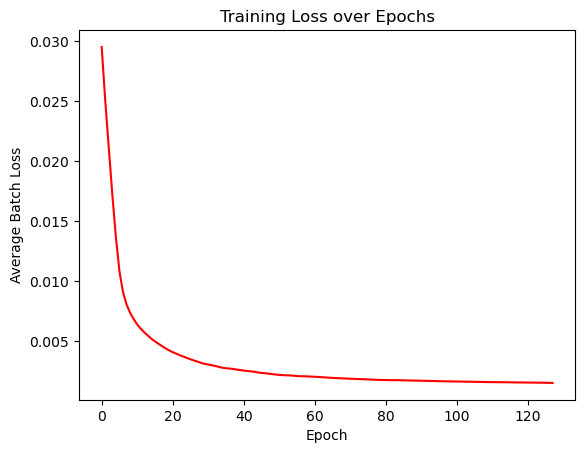

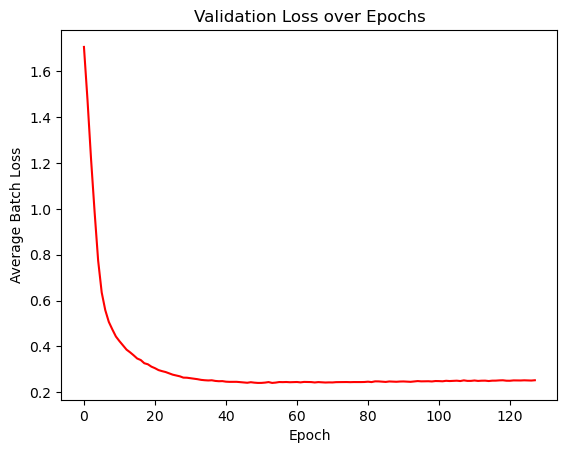

PART 7
Running Test Loop
batch: 1
original:


predicted:


difference:



batch: 2
original:


predicted:


difference:



batch: 3
original:


predicted:


difference:



batch: 4
original:


predicted:


difference:



Avg batch loss: 0.063188
Avg batch PSNR: 17.709621
Avg batch SSIM: 0.785425

TRAINING RECONSRTUCTION MODEL FOR: 1tfv40by40and240m

PART 1
PART 2
PART 3
ImgReconstructNN(
  (reconstruct_stack): Sequential(
    (0): Linear(in_features=100, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=4096, out_features=12544, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 112, 112))
    (7): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(4, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Sigmoid()
  )
)
PART 4
PART 5
-------------------------------
Epoch 1
Avg batch loss: 0.489284
-------------------------------
Epoch 8

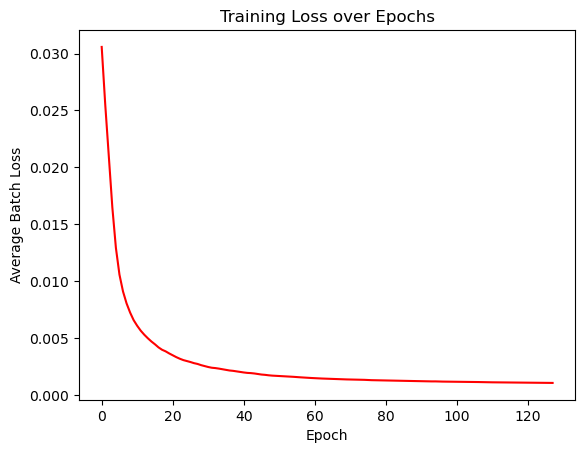

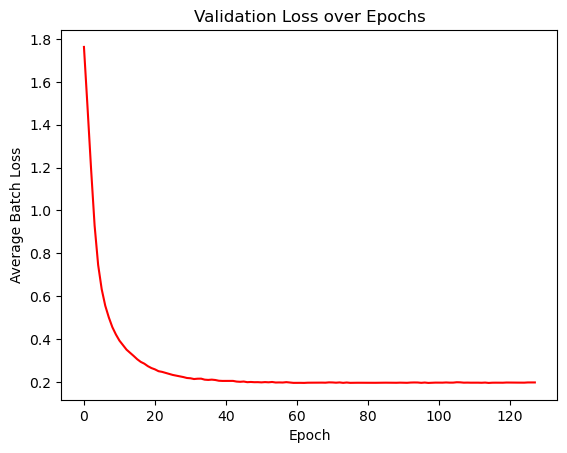

PART 7
Running Test Loop
batch: 1
original:


predicted:


difference:



batch: 2
original:


predicted:


difference:



batch: 3
original:


predicted:


difference:



batch: 4
original:


predicted:


difference:



Avg batch loss: 0.049356
Avg batch PSNR: 18.891025
Avg batch SSIM: 0.834893

TRAINING RECONSRTUCTION MODEL FOR: 200tfv40by40and240m

PART 1
PART 2
PART 3
ImgReconstructNN(
  (reconstruct_stack): Sequential(
    (0): Linear(in_features=100, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=4096, out_features=12544, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 112, 112))
    (7): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(4, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Sigmoid()
  )
)
PART 4
PART 5
-------------------------------
Epoch 1
Avg batch loss: 0.481615
-------------------------------
Epoch

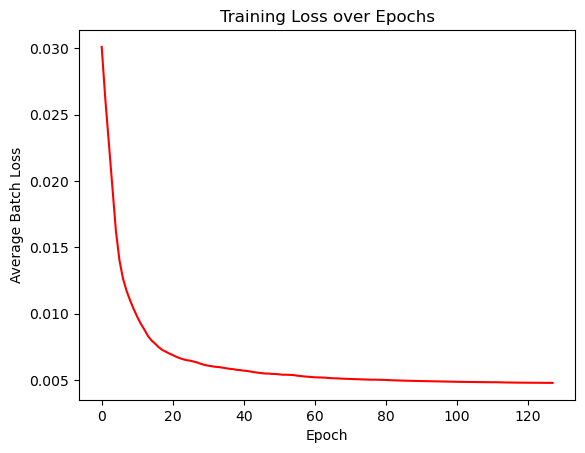

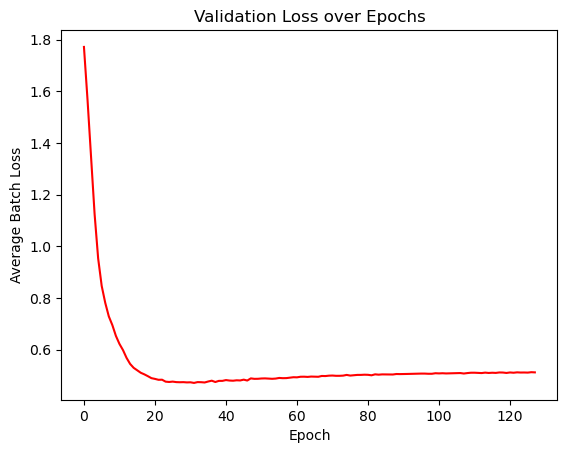

PART 7
Running Test Loop
batch: 1
original:


predicted:


difference:



batch: 2
original:


predicted:


difference:



batch: 3
original:


predicted:


difference:



batch: 4
original:


predicted:


difference:



Avg batch loss: 0.127966
Avg batch PSNR: 14.603090
Avg batch SSIM: 0.541698

TRAINING RECONSRTUCTION MODEL FOR: 20tfv40by40and240m

PART 1
PART 2
PART 3
ImgReconstructNN(
  (reconstruct_stack): Sequential(
    (0): Linear(in_features=100, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=4096, out_features=12544, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 112, 112))
    (7): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(4, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Sigmoid()
  )
)
PART 4
PART 5
-------------------------------
Epoch 1
Avg batch loss: 0.484810
-------------------------------
Epoch 

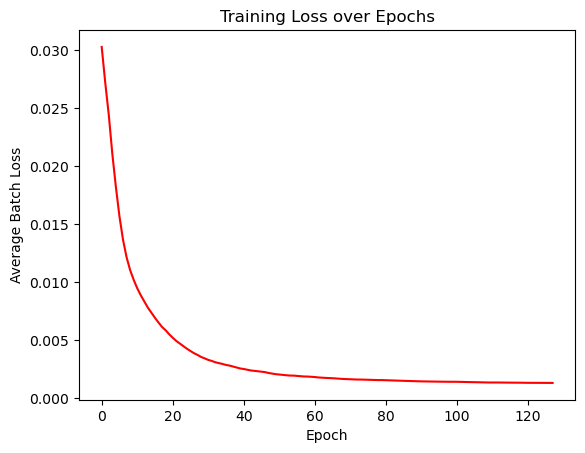

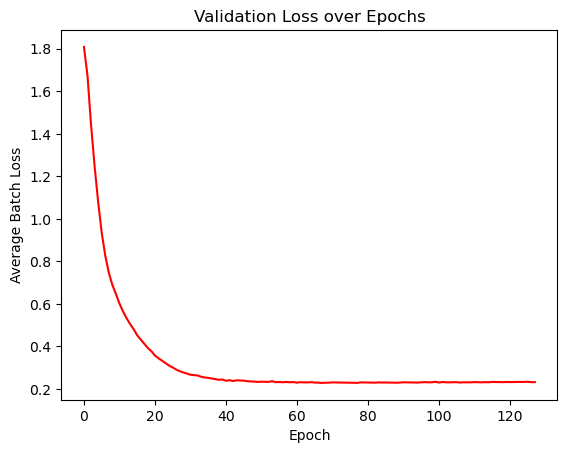

PART 7
Running Test Loop
batch: 1
original:


predicted:


difference:



batch: 2
original:


predicted:


difference:



batch: 3
original:


predicted:


difference:



batch: 4
original:


predicted:


difference:



Avg batch loss: 0.058081
Avg batch PSNR: 18.219261
Avg batch SSIM: 0.809957

TRAINING RECONSRTUCTION MODEL FOR: 2tfv40by40and240m

PART 1
PART 2
PART 3
ImgReconstructNN(
  (reconstruct_stack): Sequential(
    (0): Linear(in_features=100, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=4096, out_features=12544, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 112, 112))
    (7): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(4, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Sigmoid()
  )
)
PART 4
PART 5
-------------------------------
Epoch 1
Avg batch loss: 0.531448
-------------------------------
Epoch 8

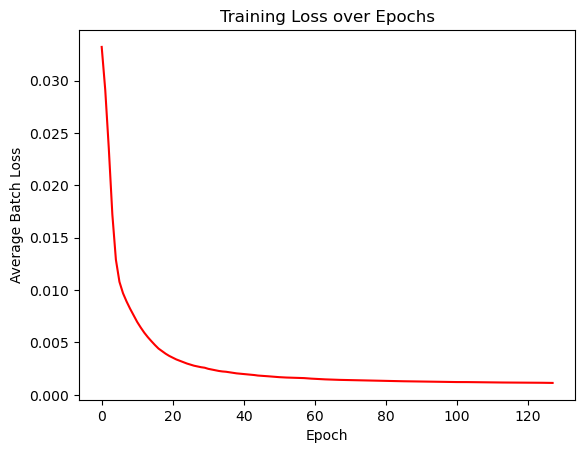

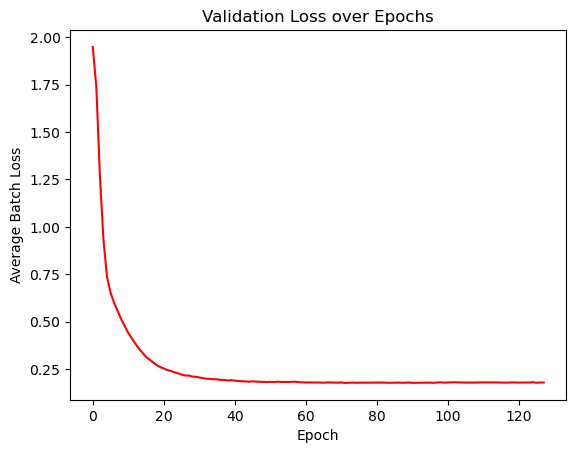

PART 7
Running Test Loop
batch: 1
original:


predicted:


difference:



batch: 2
original:


predicted:


difference:



batch: 3
original:


predicted:


difference:



batch: 4
original:


predicted:


difference:



Avg batch loss: 0.044711
Avg batch PSNR: 19.534647
Avg batch SSIM: 0.851237

TRAINING RECONSRTUCTION MODEL FOR: 50tfv40by40and240m

PART 1
PART 2
PART 3
ImgReconstructNN(
  (reconstruct_stack): Sequential(
    (0): Linear(in_features=100, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=4096, out_features=12544, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 112, 112))
    (7): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(4, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Sigmoid()
  )
)
PART 4
PART 5
-------------------------------
Epoch 1
Avg batch loss: 0.467474
-------------------------------
Epoch 

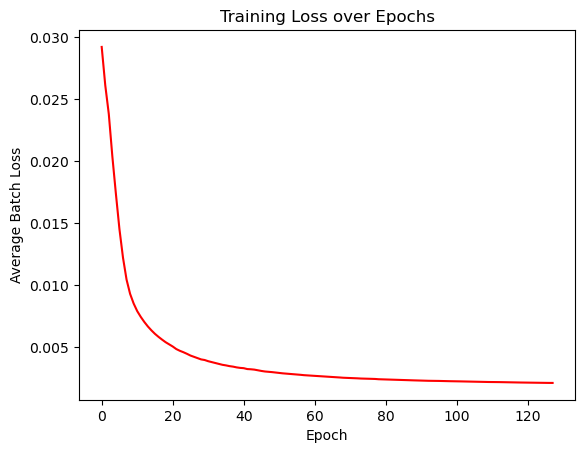

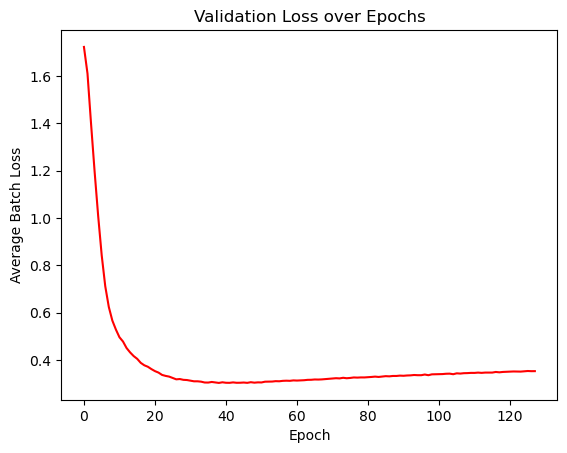

PART 7
Running Test Loop
batch: 1
original:


predicted:


difference:



batch: 2
original:


predicted:


difference:



batch: 3
original:


predicted:


difference:



batch: 4
original:


predicted:


difference:



Avg batch loss: 0.088055
Avg batch PSNR: 16.233567
Avg batch SSIM: 0.691814

TRAINING RECONSRTUCTION MODEL FOR: 5tfv40by40and240m

PART 1
PART 2
PART 3
ImgReconstructNN(
  (reconstruct_stack): Sequential(
    (0): Linear(in_features=100, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=4096, out_features=12544, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 112, 112))
    (7): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(4, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Sigmoid()
  )
)
PART 4
PART 5
-------------------------------
Epoch 1
Avg batch loss: 0.547598
-------------------------------
Epoch 8

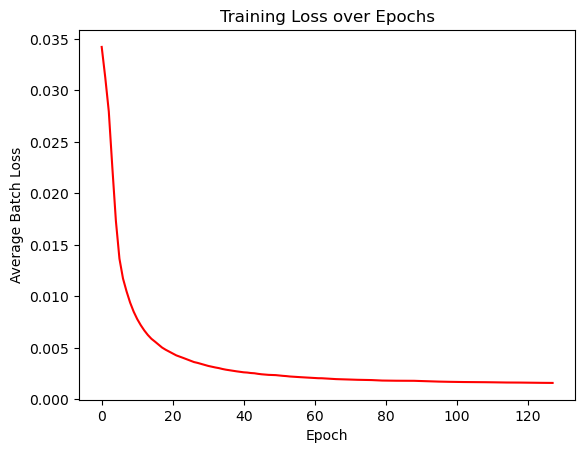

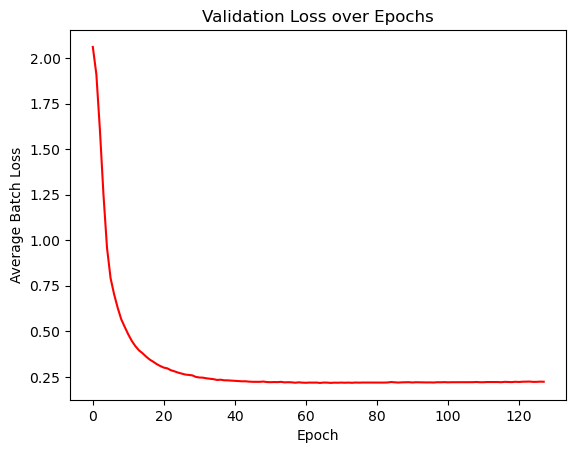

PART 7
Running Test Loop
batch: 1
original:


predicted:


difference:



batch: 2
original:


predicted:


difference:



batch: 3
original:


predicted:


difference:



batch: 4
original:


predicted:


difference:



Avg batch loss: 0.055751
Avg batch PSNR: 18.461691
Avg batch SSIM: 0.812791

TRAINING RECONSRTUCTION MODEL FOR: nnfv40by40and240m

PART 1
PART 2
PART 3
ImgReconstructNN(
  (reconstruct_stack): Sequential(
    (0): Linear(in_features=100, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=4096, out_features=12544, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 112, 112))
    (7): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(4, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Sigmoid()
  )
)
PART 4
PART 5
-------------------------------
Epoch 1
Avg batch loss: 0.505228
-------------------------------
Epoch 8

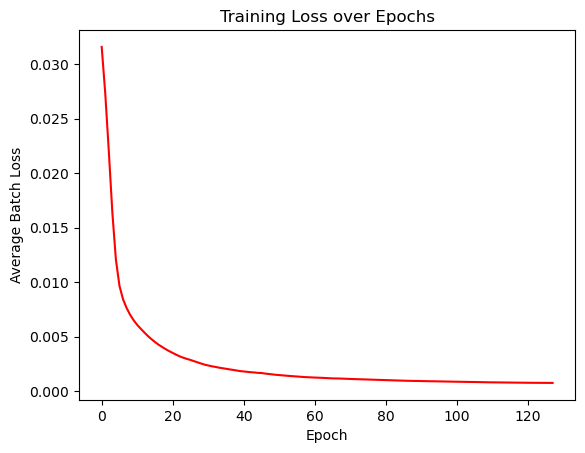

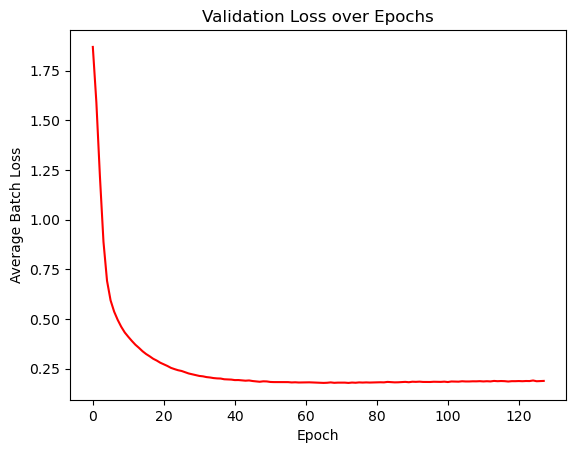

PART 7
Running Test Loop
batch: 1
original:


predicted:


difference:



batch: 2
original:


predicted:


difference:



batch: 3
original:


predicted:


difference:



batch: 4
original:


predicted:


difference:



Avg batch loss: 0.047227
Avg batch PSNR: 19.383479
Avg batch SSIM: 0.848709

TRAINING RECONSRTUCTION MODEL FOR: 100n40by40and240m

PART 1
PART 2
PART 3
ImgReconstructNN(
  (reconstruct_stack): Sequential(
    (0): Linear(in_features=100, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=4096, out_features=12544, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 112, 112))
    (7): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(4, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Sigmoid()
  )
)
PART 4
PART 5
-------------------------------
Epoch 1
Avg batch loss: 0.414342
-------------------------------
Epoch 8

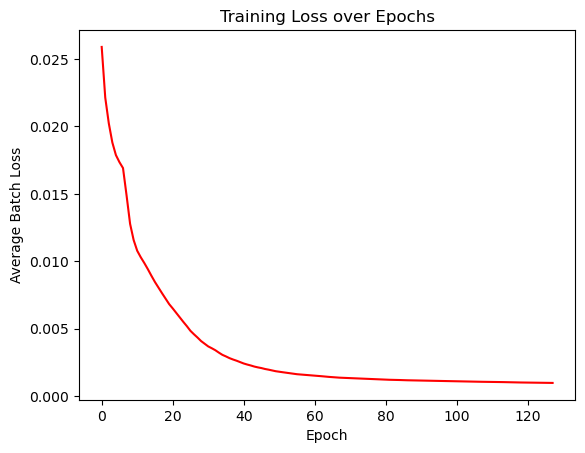

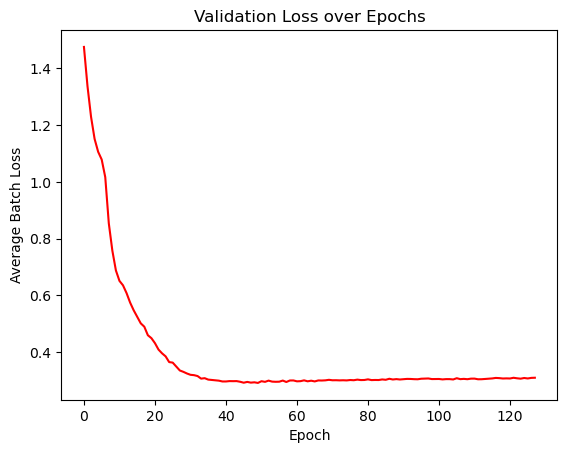

PART 7
Running Test Loop
batch: 1
original:


predicted:


difference:



batch: 2
original:


predicted:


difference:



batch: 3
original:


predicted:


difference:



batch: 4
original:


predicted:


difference:



Avg batch loss: 0.077543
Avg batch PSNR: 17.122384
Avg batch SSIM: 0.705840

TRAINING RECONSRTUCTION MODEL FOR: 37n40by40and240m

PART 1
PART 2
PART 3
ImgReconstructNN(
  (reconstruct_stack): Sequential(
    (0): Linear(in_features=100, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=4096, out_features=12544, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 112, 112))
    (7): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(4, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Sigmoid()
  )
)
PART 4
PART 5
-------------------------------
Epoch 1
Avg batch loss: 0.484638
-------------------------------
Epoch 8


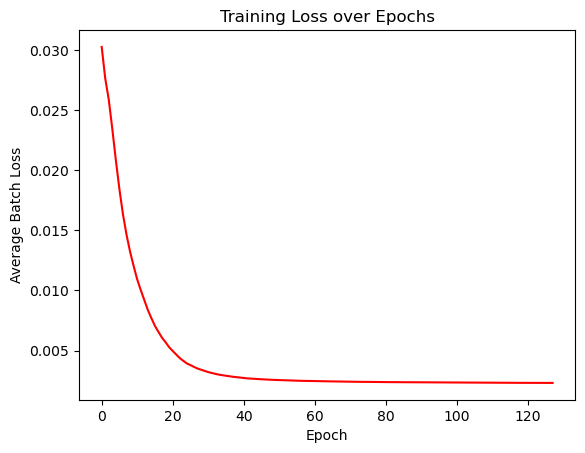

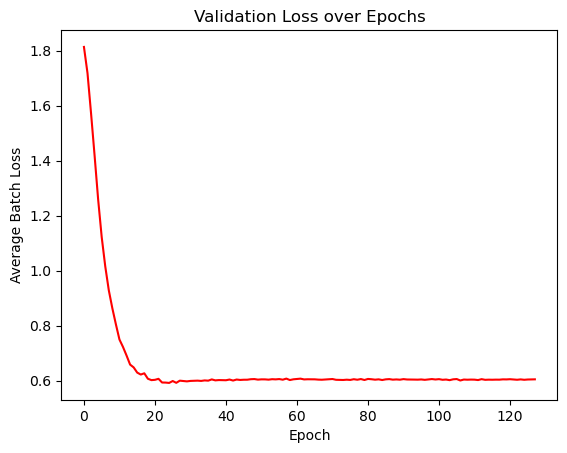

PART 7
Running Test Loop
batch: 1
original:


predicted:


difference:



batch: 2
original:


predicted:


difference:



batch: 3
original:


predicted:


difference:



batch: 4
original:


predicted:


difference:



Avg batch loss: 0.151166
Avg batch PSNR: 13.799768
Avg batch SSIM: 0.449412

TRAINING RECONSRTUCTION MODEL FOR: 50n40by40and240m

PART 1
PART 2
PART 3
ImgReconstructNN(
  (reconstruct_stack): Sequential(
    (0): Linear(in_features=100, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=4096, out_features=12544, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 112, 112))
    (7): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(4, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Sigmoid()
  )
)
PART 4
PART 5
-------------------------------
Epoch 1
Avg batch loss: 0.544320
-------------------------------
Epoch 8


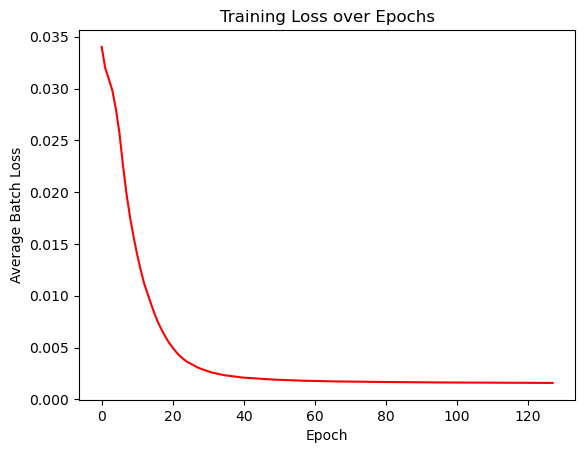

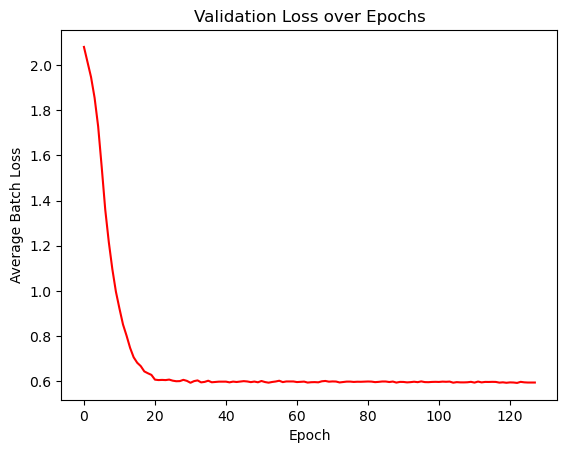

PART 7
Running Test Loop
batch: 1
original:


predicted:


difference:



batch: 2
original:


predicted:


difference:



batch: 3
original:


predicted:


difference:



batch: 4
original:


predicted:


difference:



Avg batch loss: 0.148768
Avg batch PSNR: 13.819795
Avg batch SSIM: 0.465182

TRAINING RECONSRTUCTION MODEL FOR: 62n40by40and240m

PART 1
PART 2
PART 3
ImgReconstructNN(
  (reconstruct_stack): Sequential(
    (0): Linear(in_features=100, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=4096, out_features=12544, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 112, 112))
    (7): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(4, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Sigmoid()
  )
)
PART 4
PART 5
-------------------------------
Epoch 1
Avg batch loss: 0.512551
-------------------------------
Epoch 8


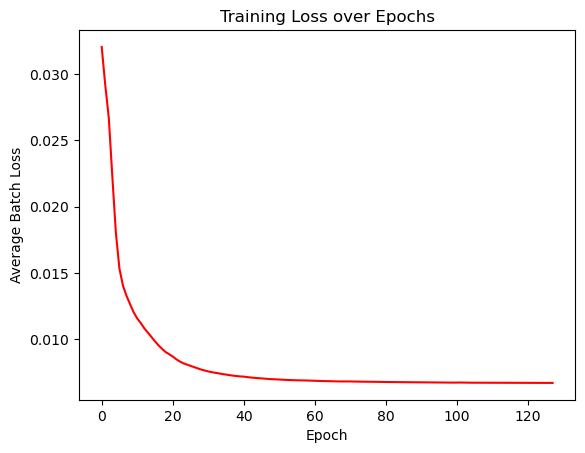

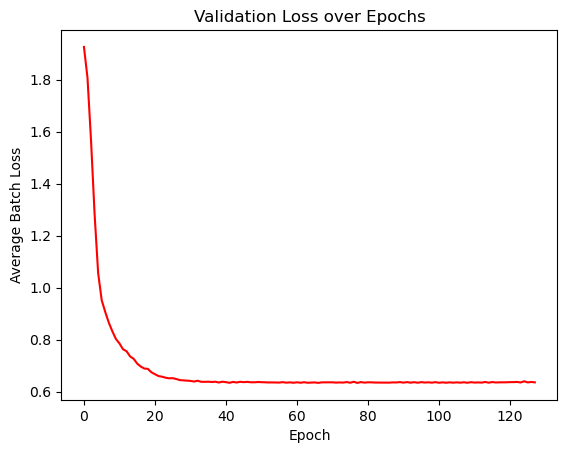

PART 7
Running Test Loop
batch: 1
original:


predicted:


difference:



batch: 2
original:


predicted:


difference:



batch: 3
original:


predicted:


difference:



batch: 4
original:


predicted:


difference:



Avg batch loss: 0.159050
Avg batch PSNR: 13.803916
Avg batch SSIM: 0.423367

TRAINING RECONSRTUCTION MODEL FOR: 75n40by40and240m

PART 1
PART 2
PART 3
ImgReconstructNN(
  (reconstruct_stack): Sequential(
    (0): Linear(in_features=100, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=4096, out_features=12544, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 112, 112))
    (7): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(4, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Sigmoid()
  )
)
PART 4
PART 5
-------------------------------
Epoch 1
Avg batch loss: 0.398060
-------------------------------
Epoch 8


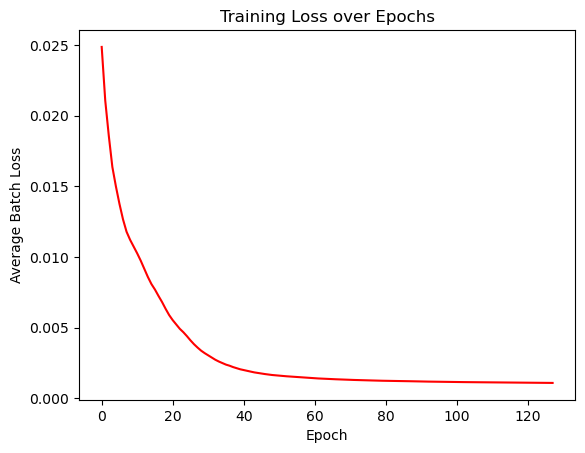

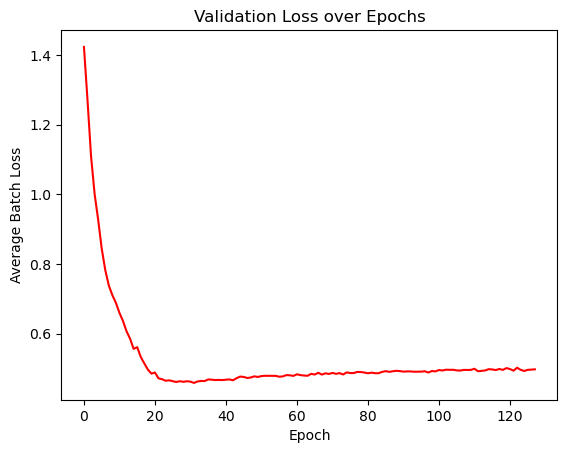

PART 7
Running Test Loop
batch: 1
original:


predicted:


difference:



batch: 2
original:


predicted:


difference:



batch: 3
original:


predicted:


difference:



batch: 4
original:


predicted:


difference:



Avg batch loss: 0.124277
Avg batch PSNR: 15.068458
Avg batch SSIM: 0.557432

TRAINING RECONSRTUCTION MODEL FOR: 87p5n40by40and240m

PART 1
PART 2
PART 3
ImgReconstructNN(
  (reconstruct_stack): Sequential(
    (0): Linear(in_features=100, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=4096, out_features=12544, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 112, 112))
    (7): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(4, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Sigmoid()
  )
)
PART 4
PART 5
-------------------------------
Epoch 1
Avg batch loss: 0.536191
-------------------------------
Epoch 

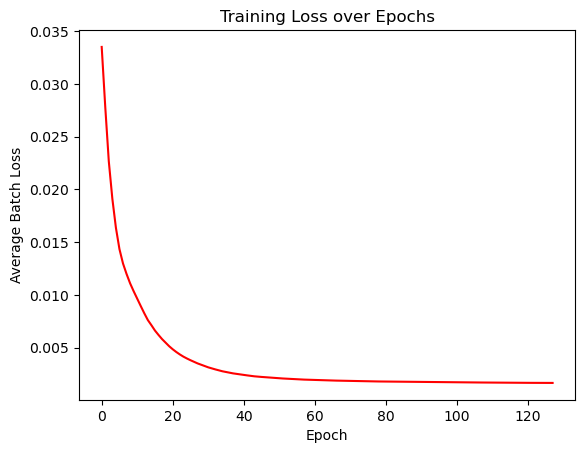

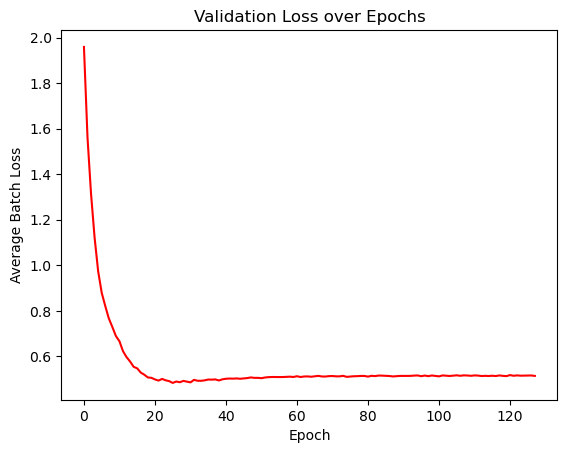

PART 7
Running Test Loop
batch: 1
original:


predicted:


difference:



batch: 2
original:


predicted:


difference:



batch: 3
original:


predicted:


difference:



batch: 4
original:


predicted:


difference:



Avg batch loss: 0.128524
Avg batch PSNR: 14.884393
Avg batch SSIM: 0.533512

TRAINING RECONSRTUCTION MODEL FOR: a25n40by40and240m

PART 1
PART 2
PART 3
ImgReconstructNN(
  (reconstruct_stack): Sequential(
    (0): Linear(in_features=100, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=4096, out_features=12544, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 112, 112))
    (7): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(4, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Sigmoid()
  )
)
PART 4
PART 5
-------------------------------
Epoch 1
Avg batch loss: 0.453119
-------------------------------
Epoch 8

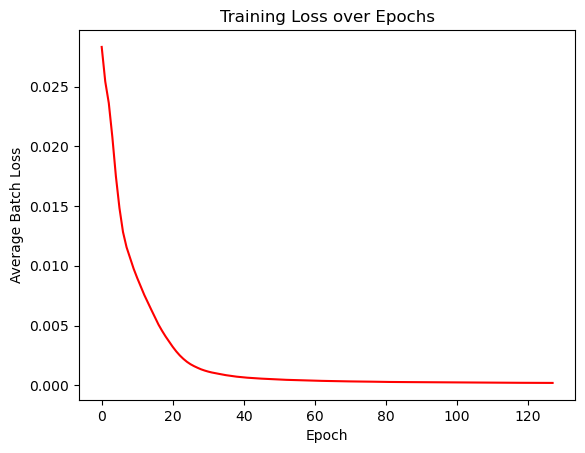

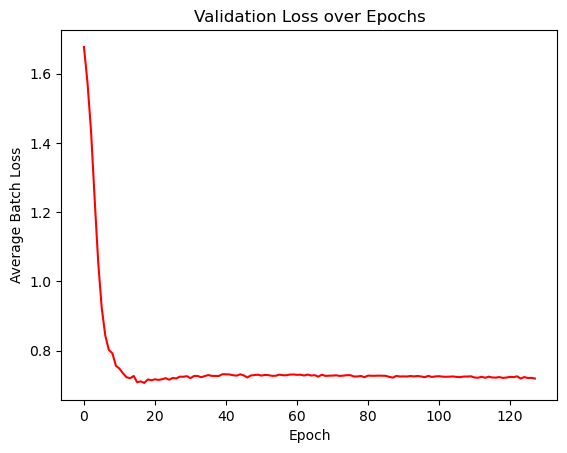

PART 7
Running Test Loop
batch: 1
original:


predicted:


difference:



batch: 2
original:


predicted:


difference:



batch: 3
original:


predicted:


difference:



batch: 4
original:


predicted:


difference:



Avg batch loss: 0.179905
Avg batch PSNR: 13.595709
Avg batch SSIM: 0.362518

TRAINING RECONSRTUCTION MODEL FOR: 10fv40by40and240m

PART 1
PART 2
PART 3
ImgReconstructNN(
  (reconstruct_stack): Sequential(
    (0): Linear(in_features=100, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=4096, out_features=12544, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 112, 112))
    (7): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(4, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Sigmoid()
  )
)
PART 4
PART 5
-------------------------------
Epoch 1
Avg batch loss: 0.470674
-------------------------------
Epoch 8

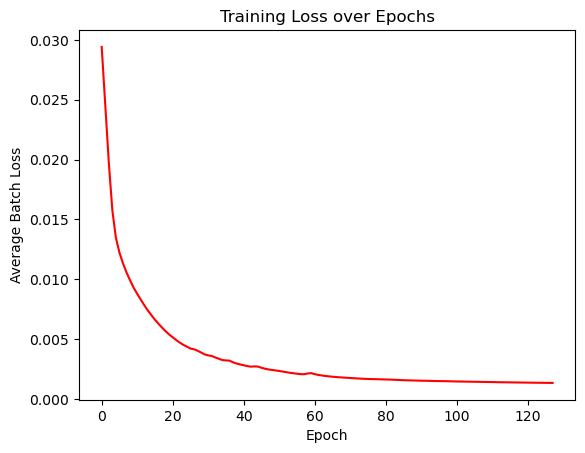

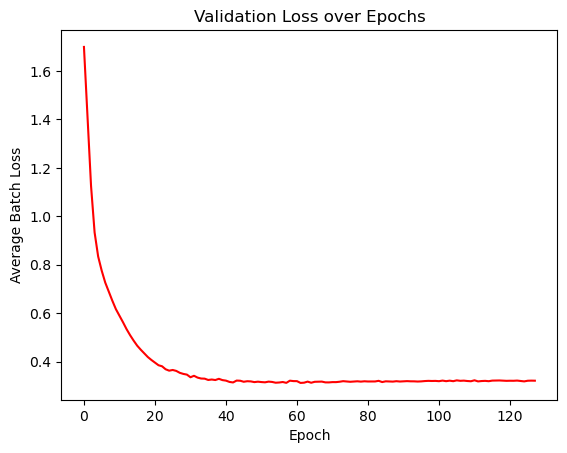

PART 7
Running Test Loop
batch: 1
original:


predicted:


difference:



batch: 2
original:


predicted:


difference:



batch: 3
original:


predicted:


difference:



batch: 4
original:


predicted:


difference:



Avg batch loss: 0.080293
Avg batch PSNR: 16.897010
Avg batch SSIM: 0.727620

TRAINING RECONSRTUCTION MODEL FOR: 3fv40by40and240m

PART 1
PART 2
PART 3
ImgReconstructNN(
  (reconstruct_stack): Sequential(
    (0): Linear(in_features=100, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=4096, out_features=12544, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 112, 112))
    (7): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(4, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Sigmoid()
  )
)
PART 4
PART 5
-------------------------------
Epoch 1
Avg batch loss: 0.529884
-------------------------------
Epoch 8


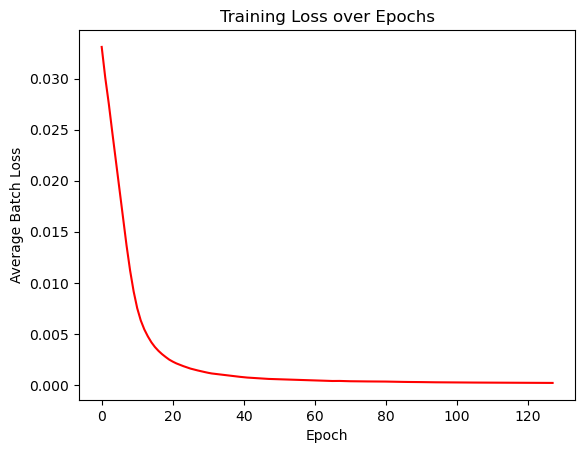

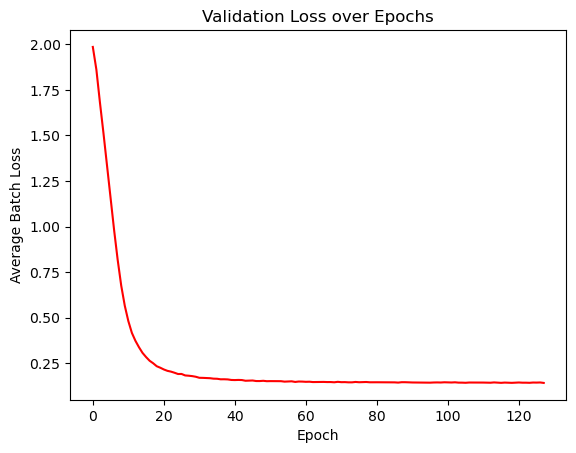

PART 7
Running Test Loop
batch: 1
original:


predicted:


difference:



batch: 2
original:


predicted:


difference:



batch: 3
original:


predicted:


difference:



batch: 4
original:


predicted:


difference:



Avg batch loss: 0.035207
Avg batch PSNR: 20.726814
Avg batch SSIM: 0.874342

TRAINING RECONSRTUCTION MODEL FOR: 7a5fv40by40and240m

PART 1
PART 2
PART 3
ImgReconstructNN(
  (reconstruct_stack): Sequential(
    (0): Linear(in_features=100, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=4096, out_features=12544, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 112, 112))
    (7): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(4, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Sigmoid()
  )
)
PART 4
PART 5
-------------------------------
Epoch 1
Avg batch loss: 0.475099
-------------------------------
Epoch 

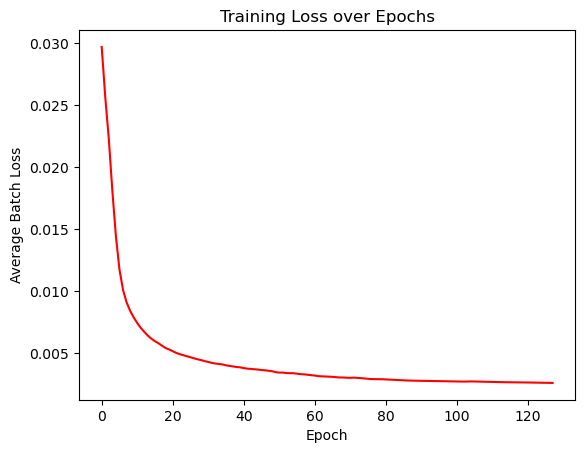

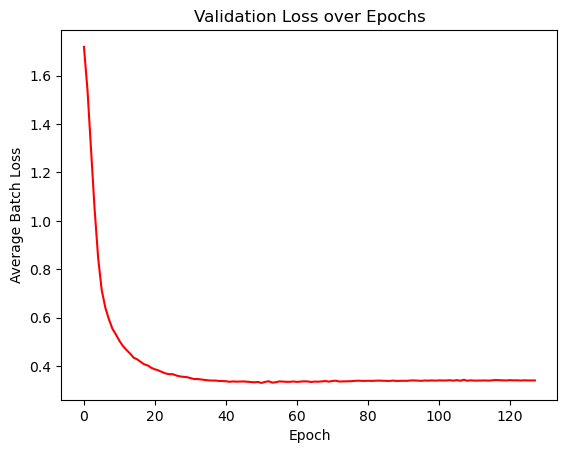

PART 7
Running Test Loop
batch: 1
original:


predicted:


difference:



batch: 2
original:


predicted:


difference:



batch: 3
original:


predicted:


difference:



batch: 4
original:


predicted:


difference:



Avg batch loss: 0.085218
Avg batch PSNR: 16.312491
Avg batch SSIM: 0.712211

TRAINING RECONSRTUCTION MODEL FOR: aa15fv40by40and240m

PART 1
PART 2
PART 3
ImgReconstructNN(
  (reconstruct_stack): Sequential(
    (0): Linear(in_features=100, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=4096, out_features=12544, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 112, 112))
    (7): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(4, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Sigmoid()
  )
)
PART 4
PART 5
-------------------------------
Epoch 1
Avg batch loss: 0.496185
-------------------------------
Epoch

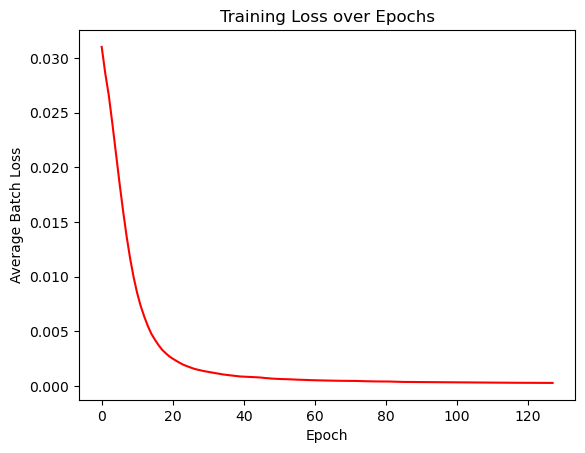

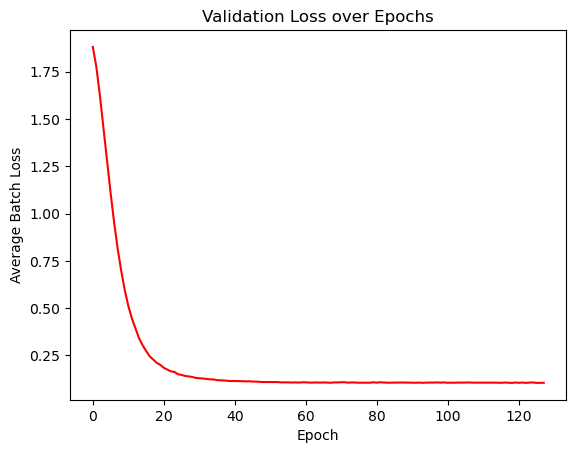

PART 7
Running Test Loop
batch: 1
original:


predicted:


difference:



batch: 2
original:


predicted:


difference:



batch: 3
original:


predicted:


difference:



batch: 4
original:


predicted:


difference:



Avg batch loss: 0.026410
Avg batch PSNR: 22.266273
Avg batch SSIM: 0.916015

TRAINING RECONSRTUCTION MODEL FOR: aa20fv40by40and240m

PART 1
PART 2
PART 3
ImgReconstructNN(
  (reconstruct_stack): Sequential(
    (0): Linear(in_features=100, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=4096, out_features=12544, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 112, 112))
    (7): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(4, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Sigmoid()
  )
)
PART 4
PART 5
-------------------------------
Epoch 1
Avg batch loss: 0.503913
-------------------------------
Epoch

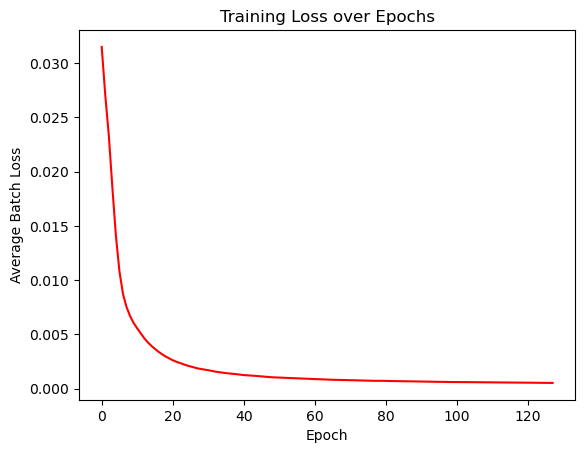

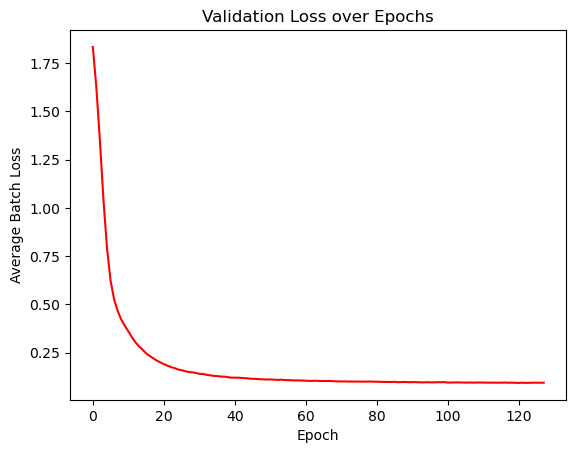

PART 7
Running Test Loop
batch: 1
original:


predicted:


difference:



batch: 2
original:


predicted:


difference:



batch: 3
original:


predicted:


difference:



batch: 4
original:


predicted:


difference:



Avg batch loss: 0.023606
Avg batch PSNR: 22.862675
Avg batch SSIM: 0.922938

TRAINING RECONSRTUCTION MODEL FOR: aa25fv40by40and240m

PART 1
PART 2
PART 3
ImgReconstructNN(
  (reconstruct_stack): Sequential(
    (0): Linear(in_features=100, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=4096, out_features=12544, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 112, 112))
    (7): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(4, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Sigmoid()
  )
)
PART 4
PART 5
-------------------------------
Epoch 1
Avg batch loss: 0.455114
-------------------------------
Epoch

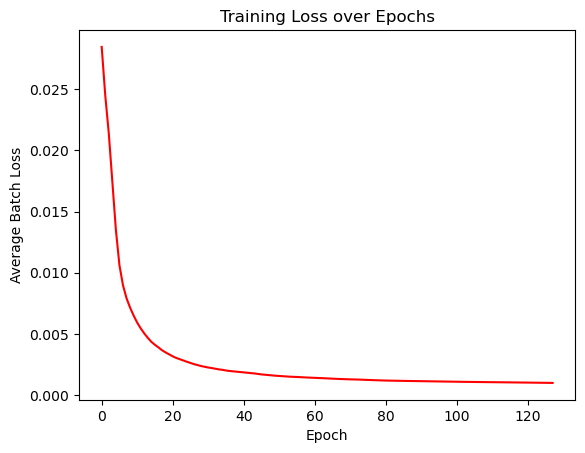

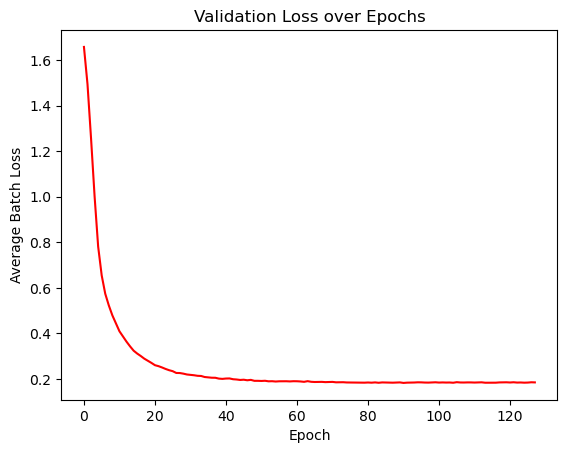

PART 7
Running Test Loop
batch: 1
original:


predicted:


difference:



batch: 2
original:


predicted:


difference:



batch: 3
original:


predicted:


difference:



batch: 4
original:


predicted:


difference:



Avg batch loss: 0.046162
Avg batch PSNR: 19.535991
Avg batch SSIM: 0.853967

TRAINING RECONSRTUCTION MODEL FOR: aa30fv40by40and240m

PART 1
PART 2
PART 3
ImgReconstructNN(
  (reconstruct_stack): Sequential(
    (0): Linear(in_features=100, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=4096, out_features=12544, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 112, 112))
    (7): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(4, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Sigmoid()
  )
)
PART 4
PART 5
-------------------------------
Epoch 1
Avg batch loss: 0.526097
-------------------------------
Epoch

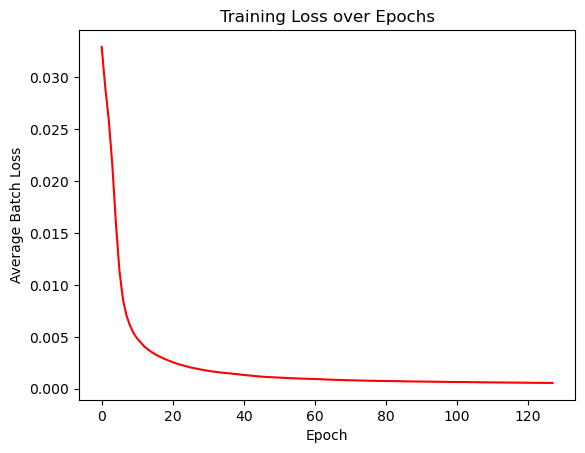

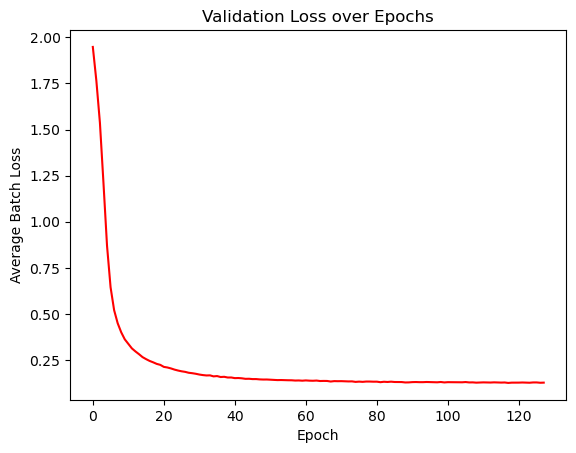

PART 7
Running Test Loop
batch: 1
original:


predicted:


difference:



batch: 2
original:


predicted:


difference:



batch: 3
original:


predicted:


difference:



batch: 4
original:


predicted:


difference:



Avg batch loss: 0.031943
Avg batch PSNR: 21.290012
Avg batch SSIM: 0.902439

TRAINING RECONSRTUCTION MODEL FOR: aa35fv40by40and240m

PART 1
PART 2
PART 3
ImgReconstructNN(
  (reconstruct_stack): Sequential(
    (0): Linear(in_features=100, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=4096, out_features=12544, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 112, 112))
    (7): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(4, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Sigmoid()
  )
)
PART 4
PART 5
-------------------------------
Epoch 1
Avg batch loss: 0.500974
-------------------------------
Epoch

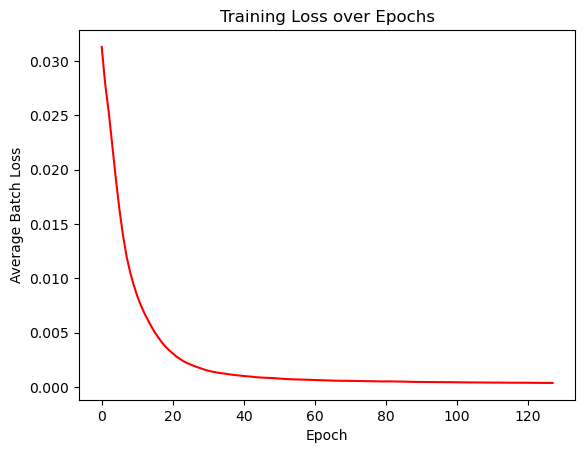

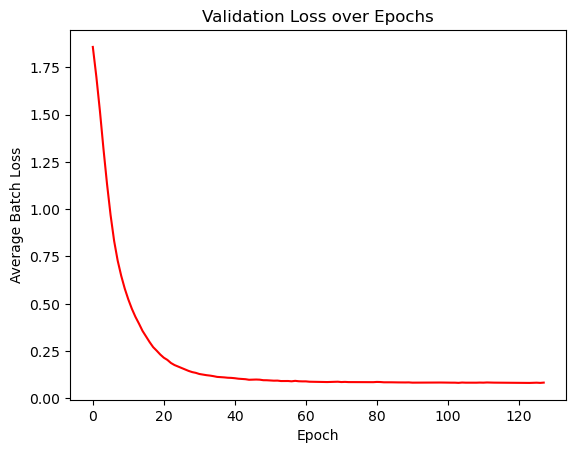

PART 7
Running Test Loop
batch: 1
original:


predicted:


difference:



batch: 2
original:


predicted:


difference:



batch: 3
original:


predicted:


difference:



batch: 4
original:


predicted:


difference:



Avg batch loss: 0.020959
Avg batch PSNR: 23.445497
Avg batch SSIM: 0.932687

TRAINING RECONSRTUCTION MODEL FOR: aa40fv40by40and240m

PART 1
PART 2
PART 3
ImgReconstructNN(
  (reconstruct_stack): Sequential(
    (0): Linear(in_features=100, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=4096, out_features=12544, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 112, 112))
    (7): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(4, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Sigmoid()
  )
)
PART 4
PART 5
-------------------------------
Epoch 1
Avg batch loss: 0.453568
-------------------------------
Epoch

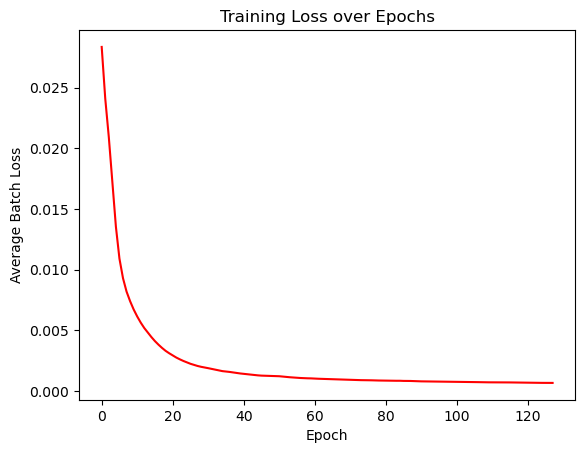

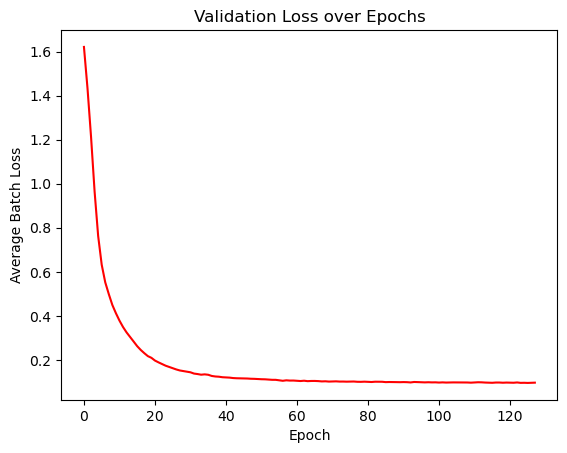

PART 7
Running Test Loop
batch: 1
original:


predicted:


difference:



batch: 2
original:


predicted:


difference:



batch: 3
original:


predicted:


difference:



batch: 4
original:


predicted:


difference:



Avg batch loss: 0.024115
Avg batch PSNR: 22.640493
Avg batch SSIM: 0.918840

TRAINING RECONSRTUCTION MODEL FOR: aa5fv40by40and240m

PART 1
PART 2
PART 3
ImgReconstructNN(
  (reconstruct_stack): Sequential(
    (0): Linear(in_features=100, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=4096, out_features=12544, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 112, 112))
    (7): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(4, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Sigmoid()
  )
)
PART 4
PART 5
-------------------------------
Epoch 1
Avg batch loss: 0.421473
-------------------------------
Epoch 

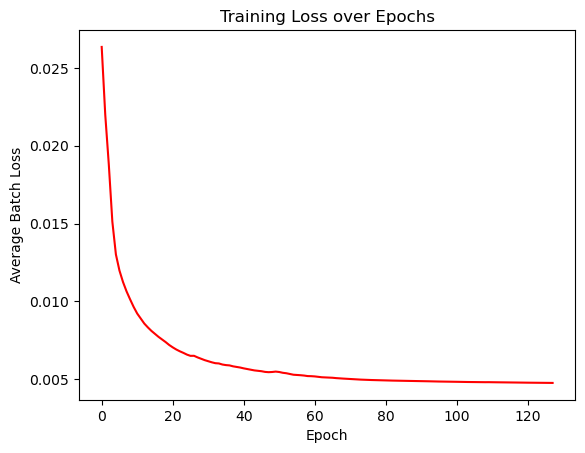

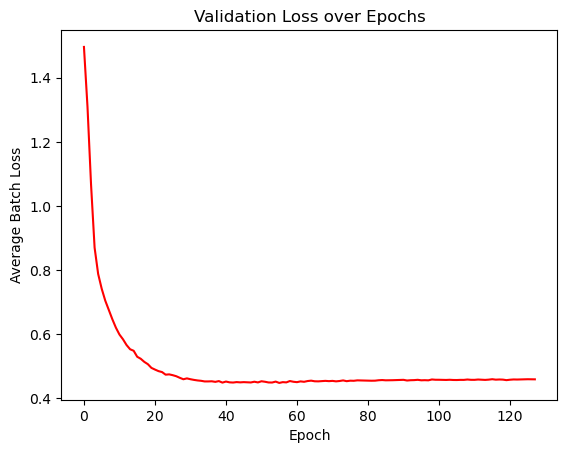

PART 7
Running Test Loop
batch: 1
original:


predicted:


difference:



batch: 2
original:


predicted:


difference:



batch: 3
original:


predicted:


difference:



batch: 4
original:


predicted:


difference:



Avg batch loss: 0.114802
Avg batch PSNR: 15.144121
Avg batch SSIM: 0.603922

TRAINING RECONSRTUCTION MODEL FOR: aa6fv40by40and240m

PART 1
PART 2
PART 3
ImgReconstructNN(
  (reconstruct_stack): Sequential(
    (0): Linear(in_features=100, out_features=1024, bias=True)
    (1): PReLU(num_parameters=1)
    (2): Linear(in_features=1024, out_features=4096, bias=True)
    (3): PReLU(num_parameters=1)
    (4): Linear(in_features=4096, out_features=12544, bias=True)
    (5): Sigmoid()
    (6): Unflatten(dim=1, unflattened_size=(1, 112, 112))
    (7): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(4, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Sigmoid()
  )
)
PART 4
PART 5
-------------------------------
Epoch 1
Avg batch loss: 0.504808
-------------------------------
Epoch 

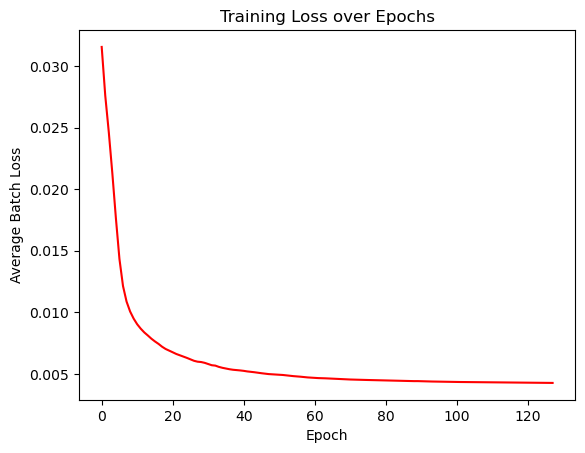

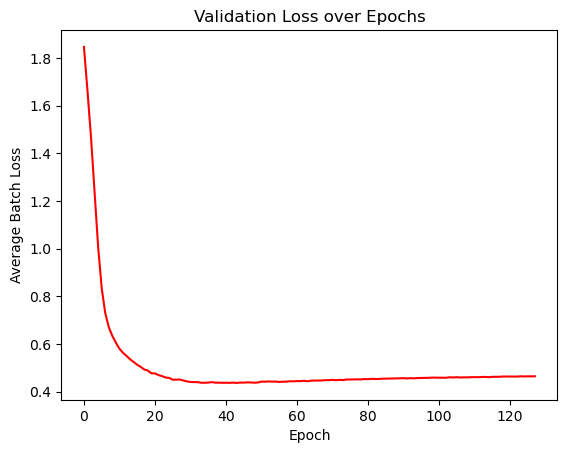

PART 7
Running Test Loop
batch: 1
original:


predicted:


difference:



batch: 2
original:


predicted:


difference:



batch: 3
original:


predicted:


difference:



batch: 4
original:


predicted:


difference:



Avg batch loss: 0.116273
Avg batch PSNR: 15.055663
Avg batch SSIM: 0.584271


In [8]:
# hyper parameters
batch_size = 50
val_size = 0.2
epochs = 128
learning_rate = 1e-3
loss_fn = L1_SSIM_loss(window_size=2, n_channels=1).to(device)

###############################################################################
# IMAGE RECONSTRUCTION
###############################################################################

# VARIED NOISE LEVELS
results = {}
results['detection_type'] = []
results['filename'] = []
results['val_loss'] = []
results['val_psnr'] = []
results['val_ssim'] = []
for filename in os.listdir(f'../data/features/ASE_noise/direct_detection'):
    val_loss, val_psnr, val_ssim = reconstruct("ASE_noise", "direct_detection", filename, batch_size, val_size, epochs, loss_fn, learning_rate)
    results['detection_type'].append("Direct Detection")
    results['filename'].append(filename)
    results['val_loss'].append(val_loss)
    results['val_psnr'].append(val_psnr)
    results['val_ssim'].append(val_ssim)
for filename in os.listdir(f'../data/features/ASE_noise/QPMS'):
    val_loss, val_psnr, val_ssim = reconstruct("ASE_noise", "QPMS", filename, batch_size, val_size, epochs, loss_fn, learning_rate)
    results['detection_type'].append("QPMS")
    results['filename'].append(filename)
    results['val_loss'].append(val_loss)
    results['val_psnr'].append(val_psnr)
    results['val_ssim'].append(val_ssim)
results = pd.DataFrame.from_dict(results)
filename = '../data/features/ASE_noise/100_reconstruction_results.csv'
results.to_csv(filename, index=False)


# VARIED INTEGRATION TIMES
results = {}
results['detection_type'] = []
results['filename'] = []
results['val_loss'] = []
results['val_psnr'] = []
results['val_ssim'] = []
for filename in os.listdir(f'../data/features/integration_time/direct_detection'):
    val_loss, val_psnr, val_ssim = reconstruct("integration_time", "direct_detection", filename, batch_size, val_size, epochs, loss_fn, learning_rate)
    results['detection_type'].append("Direct Detection")
    results['filename'].append(filename)
    results['val_loss'].append(val_loss)
    results['val_psnr'].append(val_psnr)
    results['val_ssim'].append(val_ssim)
for filename in os.listdir(f'../data/features/integration_time/QPMS'):
    val_loss, val_psnr, val_ssim = reconstruct("integration_time", "QPMS", filename, batch_size, val_size, epochs, loss_fn, learning_rate)
    results['detection_type'].append("QPMS")
    results['filename'].append(filename)
    results['val_loss'].append(val_loss)
    results['val_psnr'].append(val_psnr)
    results['val_ssim'].append(val_ssim)
results = pd.DataFrame.from_dict(results)
filename = '../data/features/integration_time/100_reconstruction_results.csv'
results.to_csv(filename, index=False)